In [94]:
# Copyright (C) 2023, Advanced Micro Devices, Inc.
# Stack Overflow (c) by Stack Exchange, Inc. 

# Stack Overflow is licensed under a
# Creative Commons Attribution-ShareAlike 4.0 International License.

# You should have received a copy of the license along with this
# work. If not, see <http://creativecommons.org/licenses/by-sa/4.0/>.

import os
import re
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [95]:
"""
Helper functions
"""
def parse_random_search_experiment(experiment_dir):
    """
    Parse experiment directory into dataframe
    """
    emd_files = []
    hparam_files = []
    lutcost_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        emd_file_found = False
        if os.path.isdir(single_run_dir):
            # Find emd file
            for f in os.listdir(single_run_dir):
                if "emd" in f:
                    emd_file_found = True
                    emd_files.append(os.path.join(experiment_dir, d, f))
            if emd_file_found:
                for f in os.listdir(single_run_dir):
                    if "hparams.yml" in f:
                        hparam_files.append(os.path.join(experiment_dir, d, f))
                    if "lutcost" in f:
                        lutcost_files.append(os.path.join(experiment_dir, d, f))

    assert len(emd_files) == len(hparam_files), f"num emd files = {len(emd_files)}, num hparam files = {len(hparam_files)}"
    assert len(emd_files) == len(lutcost_files), f"num emd files = {len(emd_files)}, num lutcost files = {len(lutcost_files)}"

    lr = 0
    wd = 0
    lr_t0 = 0
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,emd,lut_cost,loss,hidden_layers,act_bits,neuron_fanin,input_bits,input_fanin,output_bits,lr,lr_t0,wd\n")
    for emd_f, hp_f, lut_f in zip(emd_files, hparam_files, lutcost_files):
        # Get EMD
        with open(emd_f, "r") as f:
            emd = float(f.readlines()[-1])
        trial = emd_f.split("/")[-2]
        # Get loss
        txt_file = emd_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[0])
        # Get total lut cost
        with open(lut_f, "r") as f:
            lut_str = f.readlines()[-1]
            lut_cost = float(re.findall(f"\d+", lut_str)[0])
        # Parse hparam yml
        with open(hp_f, "r") as f:
            hps = yaml.safe_load(f)
        hidden_layers = str(hps["hidden_layer"]).replace(",", ";")
        act_bits = str(hps["activation_bitwidth"]).replace(",", ";")
        neuron_fanin = str(hps["neuron_fanin"]).replace(",", ";")
        input_bits = hps["input_bitwidth"]
        input_fanin = hps["input_fanin"]
        output_bits = hps["output_bitwidth"]
        lr = hps["lr"]
        lr_t0 = hps["warm_restart_freq"]
        wd = hps["wd"]
        with open(results_file, "a") as f:
            f.write(f"{trial}, {emd:.3f}, {lut_cost}, {loss:.3f}, {hidden_layers}, {act_bits}, {neuron_fanin}, {input_bits}, {input_fanin}, {output_bits}, {lr:.5f}, {lr_t0}, {wd:5f}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("emd", ignore_index=True)
    df.to_csv(results_file, index=False)
    return df

def parse_grid_search_experiment(experiment_dir):
    """
    Parse grid search experiment directory into dataframe
    """
    emd_files = []
    hparam_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        emd_file_found = False
        if os.path.isdir(single_run_dir):
            # Find emd file
            for f in os.listdir(single_run_dir):
                if "emd" in f:
                    emd_file_found = True
                    emd_files.append(os.path.join(experiment_dir, d, f))
            if emd_file_found:
                for f in os.listdir(single_run_dir):
                    if "hparams.yml" in f:
                        hparam_files.append(os.path.join(experiment_dir, d, f))

    assert len(emd_files) == len(hparam_files), f"num emd files = {len(emd_files)}, num hparam files = {len(hparam_files)}"

    lr = 0
    wd = 0
    lr_t0 = 0
    batch_size = 0
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,emd,loss,hidden_layers,act_bits,neuron_fanin,input_bits,input_fanin,output_bits,lr,lr_t0,wd,batch_size\n")
    for emd_f, hp_f in zip(emd_files, hparam_files):
        # Example emd file
        # large_lr0.01_warm_restart_freq25_wd0.1_batch_size512/checkpoint_epoch24_loss=0.016.pth
        # Get EMD
        with open(emd_f, "r") as f:
            emd = float(f.readlines()[-1])
        trial = emd_f.split("/")[-2]
        # Get loss
        txt_file = emd_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        # Parse hparam yml
        with open(hp_f, "r") as f:
            hps = yaml.safe_load(f)
        hidden_layers = str(hps["hidden_layer"]).replace(",", ";")
        act_bits = str(hps["activation_bitwidth"]).replace(",", ";")
        neuron_fanin = str(hps["neuron_fanin"]).replace(",", ";")
        input_bits = hps["input_bitwidth"]
        input_fanin = hps["input_fanin"]
        output_bits = hps["output_bitwidth"]
        lr = hps["lr"]
        lr_t0 = hps["warm_restart_freq"]
        wd = hps["wd"]
        batch_size = hps["batch_size"]
        with open(results_file, "a") as f:
            f.write(f"{trial}, {emd:.3f}, {loss:.3f}, {hidden_layers}, {act_bits}, {neuron_fanin}, {input_bits}, {input_fanin}, {output_bits}, {lr:.5f}, {lr_t0}, {wd:5f}, {batch_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("emd", ignore_index=True)
    df.to_csv(results_file, index=False)
    return df

# LogicNets Dense-only Random Search

In [3]:
experiment_dir = "../hp_random_search/"

df = parse_random_search_experiment(experiment_dir)
df

,trial,emd,lut_cost,loss,hidden_layers,act_bits,neuron_fanin,input_bits,input_fanin,output_bits,lr,lr_t0,wd
0,hparam8_1916071045,1.419,2140224.0,0.012,[512; 256; 512; 512],[3; 4; 6; 3],[5; 3; 2; 2],5,3,4,0.00530,54,0.000566
1,hparam17_432384445,1.434,442768.0,0.012,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.00211,74,0.013042
2,hparam17_1841208793,1.463,442768.0,0.012,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.00211,74,0.013042
3,hparam17_288518158,1.463,442768.0,0.013,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.00211,74,0.013042
4,hparam8_1317947088,1.468,2140224.0,0.012,[512; 256; 512; 512],[3; 4; 6; 3],[5; 3; 2; 2],5,3,4,0.00530,54,0.000566
...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,hparam22_923386753,3.412,175232.0,0.157,[256; 64; 64; 256; 64],[2; 5; 2; 2; 2],[3; 3; 6; 3; 4],6,2,4,0.00982,72,0.023980
482,hparam21_1664274912,3.476,497984.0,0.198,[64; 128; 512; 256; 512],[2; 3; 4; 2; 4],[5; 4; 3; 4; 4],4,4,4,0.00719,60,0.060653
483,hparam22_1333950286,3.477,191072.0,0.198,[64; 64; 64],[2; 5; 3],[6; 3; 5],6,2,2,0.00640,88,0.070434
484,hparam18_703051094,3.481,840432.0,0.198,[256; 256; 128; 256; 128],[2; 4; 4; 2; 4],[6; 3; 4; 2; 2],5,2,3,0.00827,72,0.087084


In [27]:
def get_len(val):
    """
    Convert val : string to list to count length
    """
    l = eval(val.replace(";", ","))
    return len(l)

def get_max(val):
    """
    Evaluate val as list and get max value
    """
    l = eval(val.replace(";", ","))
    return max(l)

df["depth"] = df["hidden_layers"].apply(get_len)
df["max_width"] = df["hidden_layers"].apply(get_max)
df["input_bits_x_fanin"] = list(zip(df["input_bits"], df["input_fanin"]))
df

,trial,emd,lut_cost,loss,hidden_layers,act_bits,neuron_fanin,input_bits,input_fanin,output_bits,lr,lr_t0,wd,depth,max_width,input_bits_x_fanin
0,hparam8_1916071045,1.419,2140224.0,0.012,[512; 256; 512; 512],[3; 4; 6; 3],[5; 3; 2; 2],5,3,4,0.00530,54,0.000566,4,512,"(5, 3)"
1,hparam17_432384445,1.434,442768.0,0.012,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.00211,74,0.013042,3,512,"(6, 2)"
2,hparam17_288518158,1.463,442768.0,0.013,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.00211,74,0.013042,3,512,"(6, 2)"
3,hparam17_1841208793,1.463,442768.0,0.012,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.00211,74,0.013042,3,512,"(6, 2)"
4,hparam8_1317947088,1.468,2140224.0,0.012,[512; 256; 512; 512],[3; 4; 6; 3],[5; 3; 2; 2],5,3,4,0.00530,54,0.000566,4,512,"(5, 3)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,hparam22_923386753,3.412,175232.0,0.157,[256; 64; 64; 256; 64],[2; 5; 2; 2; 2],[3; 3; 6; 3; 4],6,2,4,0.00982,72,0.023980,5,256,"(6, 2)"
482,hparam21_1664274912,3.476,497984.0,0.198,[64; 128; 512; 256; 512],[2; 3; 4; 2; 4],[5; 4; 3; 4; 4],4,4,4,0.00719,60,0.060653,5,512,"(4, 4)"
483,hparam22_1333950286,3.477,191072.0,0.198,[64; 64; 64],[2; 5; 3],[6; 3; 5],6,2,2,0.00640,88,0.070434,3,64,"(6, 2)"
484,hparam18_703051094,3.481,840432.0,0.198,[256; 256; 128; 256; 128],[2; 4; 4; 2; 4],[6; 3; 4; 2; 2],5,2,3,0.00827,72,0.087084,5,256,"(5, 2)"


/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


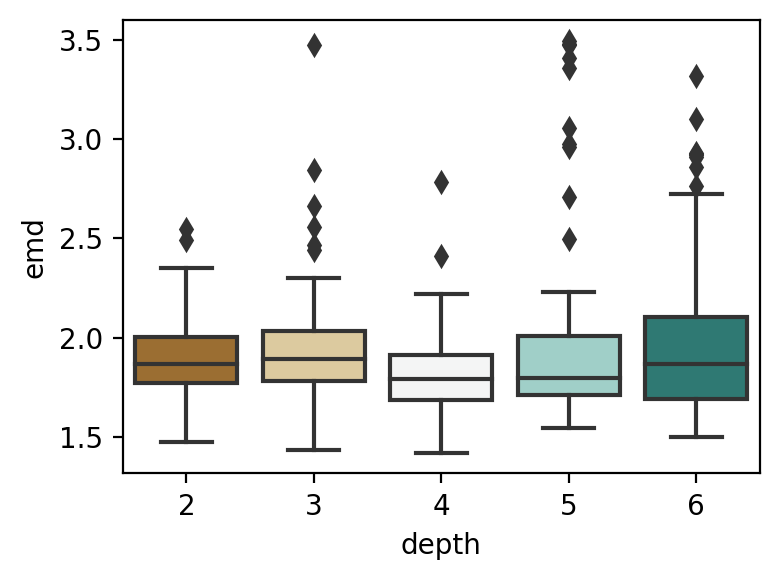

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.boxplot(data=df, x="depth", y="emd", ax=ax, palette="BrBG")

fig.tight_layout()
plt.savefig("emd_v_depth_boxplot.pdf")
plt.savefig("emd_v_depth_boxplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


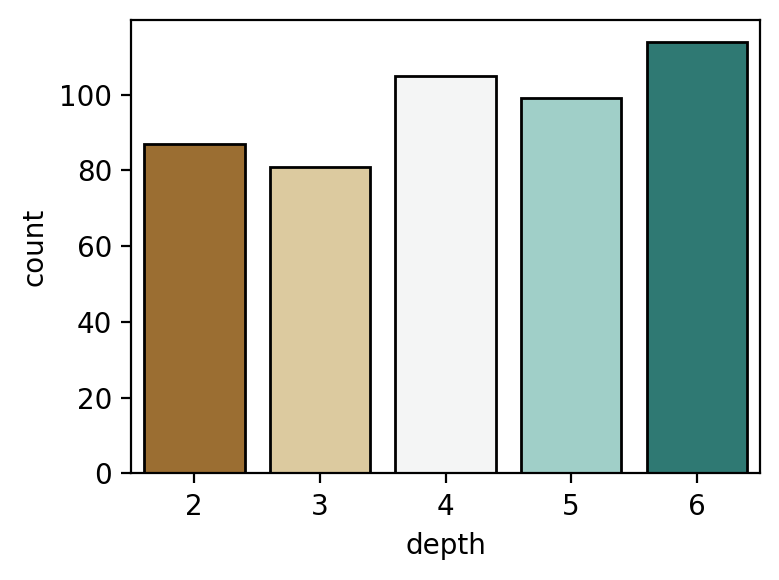

In [6]:
"""
Bar plot to count number of trials with a neural network of certain depth
"""
fig, ax = plt.subplots(figsize=(4, 3))

ax = sns.countplot(data=df, x="depth", ax=ax, palette="BrBG", edgecolor="k")

fig.tight_layout()
plt.savefig("nn_depth_count.pdf")
plt.savefig("nn_depth_count.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


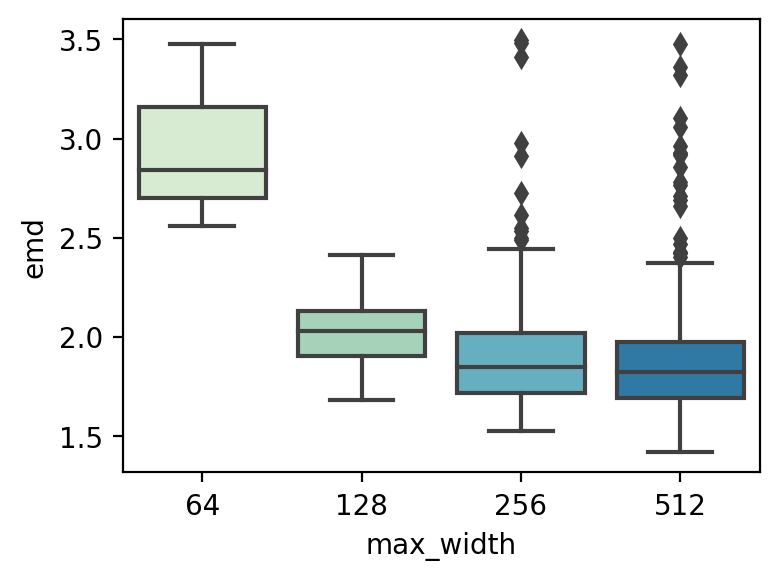

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.boxplot(data=df, x="max_width", y="emd", ax=ax, palette="GnBu")

fig.tight_layout()
plt.savefig("emd_v_max_width_boxplot.pdf")
plt.savefig("emd_v_max_width_boxplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


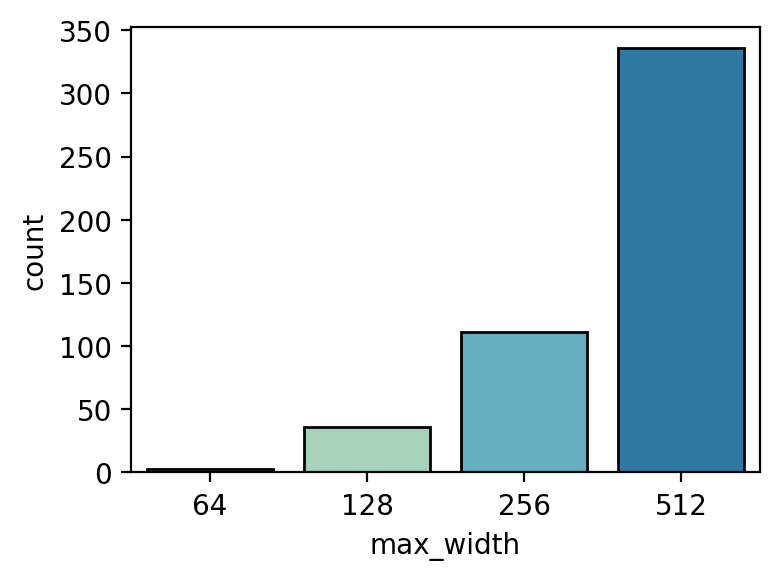

In [8]:
"""
Bar plot to count number of trials with a neural network of max width
"""
fig, ax = plt.subplots(figsize=(4, 3))

ax = sns.countplot(data=df, x="max_width", ax=ax, palette="GnBu", edgecolor="k")

fig.tight_layout()
plt.savefig("nn_max_width_count.pdf")
plt.savefig("nn_max_width_count.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1785453/2680488147.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=df, x="lr", y="emd", ax=ax, palette="pastel")


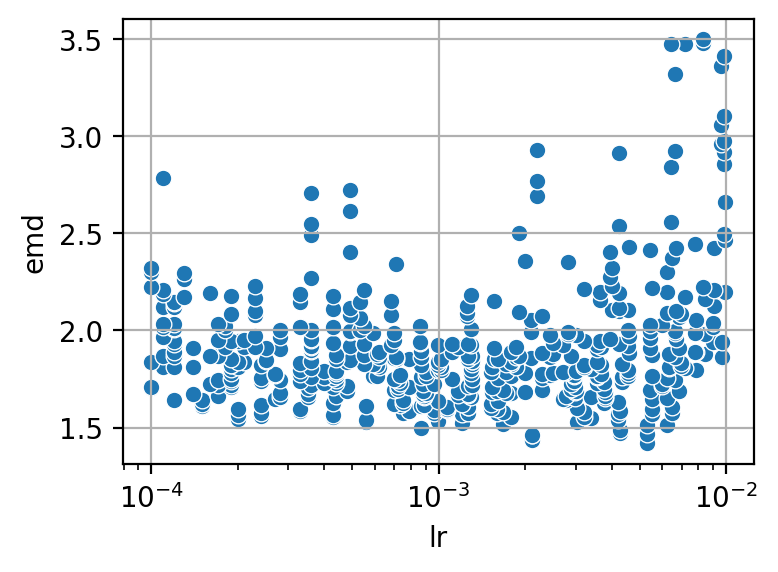

In [9]:
"""
Scatter plot EMD vs learning rate
"""
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.scatterplot(data=df, x="lr", y="emd", ax=ax, palette="pastel")

ax.set_xscale("log")
ax.grid()

fig.tight_layout()
plt.savefig("emd_v_lr_scatterplot.pdf")
plt.savefig("emd_v_lr_scatterplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1785453/2298605004.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=df, x="lr_t0", y="emd", ax=ax, palette="pastel")


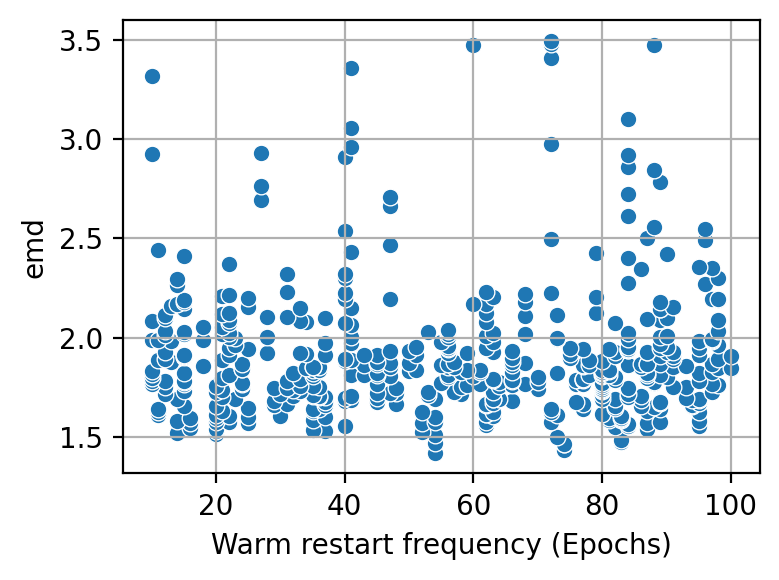

In [10]:
"""
Scatter plot EMD vs warm restart frequency
"""
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.scatterplot(data=df, x="lr_t0", y="emd", ax=ax, palette="pastel")

ax.grid()
ax.set_xlabel("Warm restart frequency (Epochs)")

fig.tight_layout()
plt.savefig("emd_v_lr_t0_scatterplot.pdf")
plt.savefig("emd_v_lr_t0_scatterplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1785453/2479843373.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=df, x="wd", y="emd", ax=ax, palette="pastel")


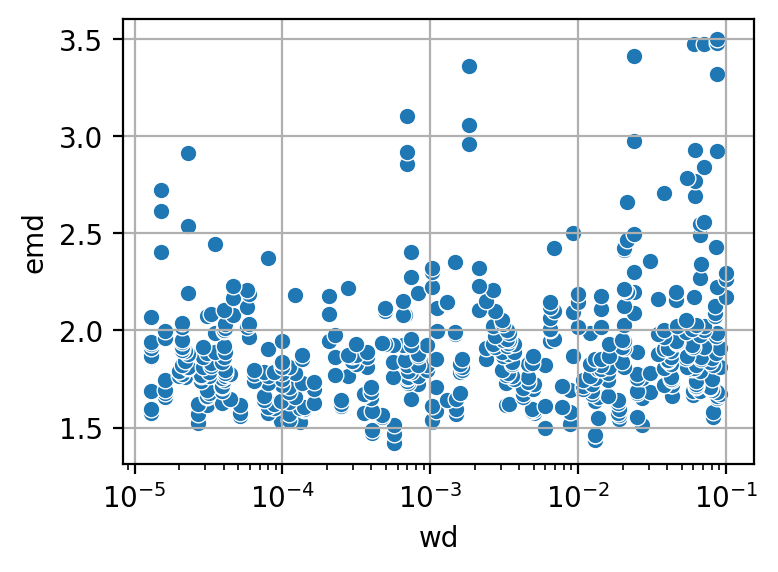

In [11]:
"""
Scatter plot EMD vs weight decay
"""
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.scatterplot(data=df, x="wd", y="emd", ax=ax, palette="pastel")

ax.set_xscale("log")
ax.grid()

fig.tight_layout()
plt.savefig("emd_v_wd_scatterplot.pdf")
plt.savefig("emd_v_wd_scatterplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


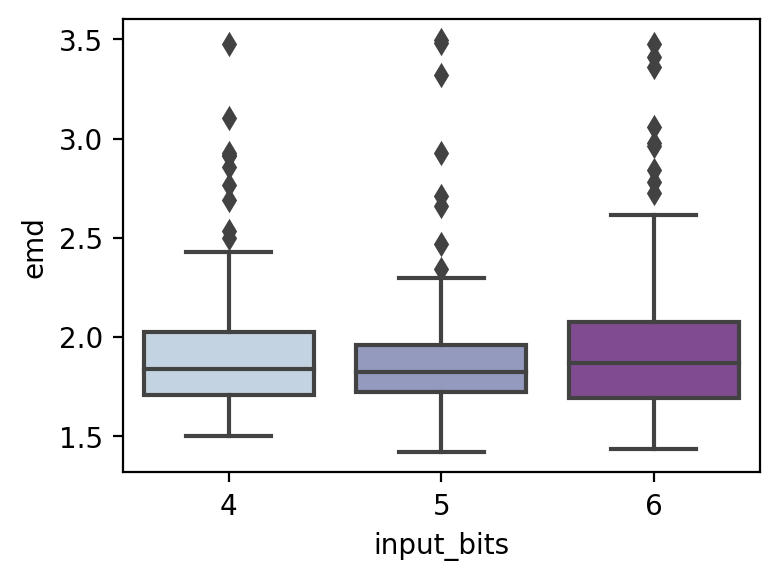

In [12]:
"""
Box plot EMD vs number of input_bits
"""
fig, ax = plt.subplots(figsize=(4, 3))
sns.boxplot(data=df, x="input_bits", y="emd", ax=ax, palette="BuPu")

fig.tight_layout()
plt.savefig("emd_v_input_bits_boxplot.pdf")
plt.savefig("emd_v_input_bits_boxplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


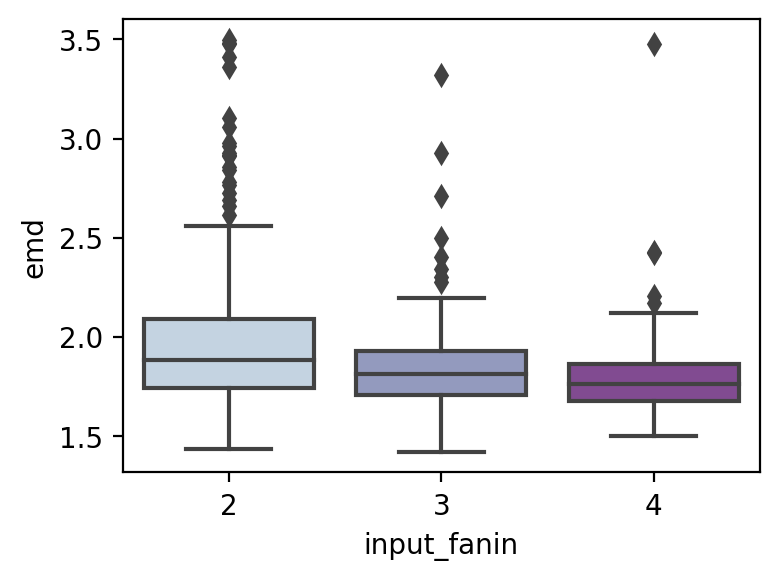

In [13]:
"""
Scatter plot EMD vs input fanin
"""
fig, ax = plt.subplots(figsize=(4, 3))
sns.boxplot(data=df, x="input_fanin", y="emd", ax=ax, palette="BuPu")

fig.tight_layout()
plt.savefig("emd_v_input_fanin_boxplot.pdf")
plt.savefig("emd_v_input_fanin_boxplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


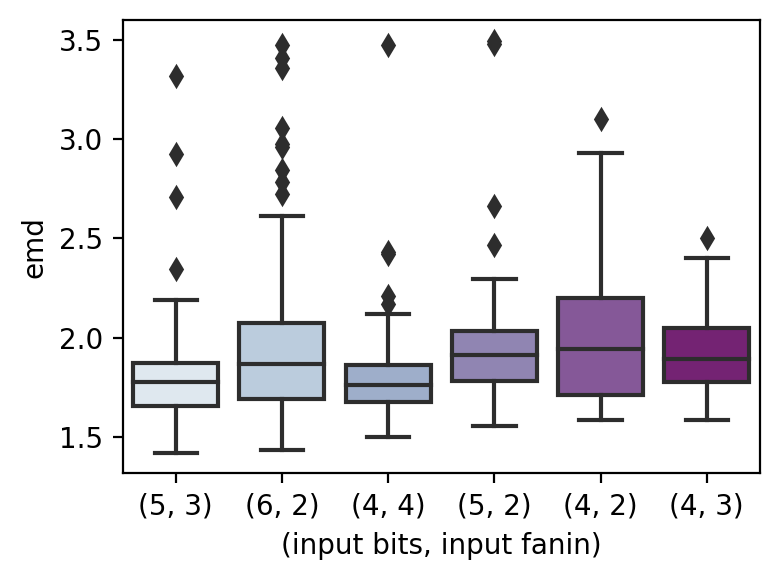

In [14]:
"""
Box plot EMD vs input_bits_x_fanin
"""
fig, ax = plt.subplots(figsize=(4, 3))
sns.boxplot(data=df, x="input_bits_x_fanin", y="emd", ax=ax, palette="BuPu")

ax.set_xlabel("(input bits, input fanin)")

fig.tight_layout()
plt.savefig("emd_v_input_bits_x_fanin_boxplot.pdf")
plt.savefig("emd_v_input_bits_x_fanin_boxplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


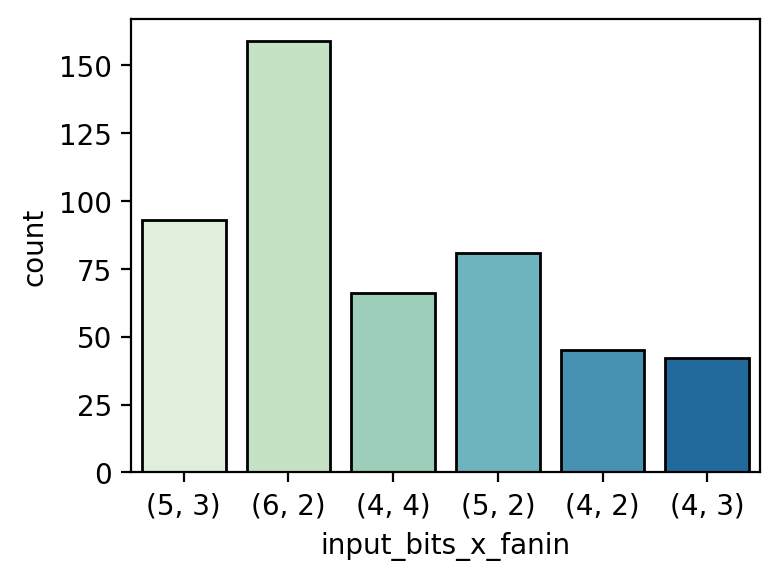

In [15]:
"""
Bar plot to count number of trials with a neural network with setting (input bits, input fanin)
"""
fig, ax = plt.subplots(figsize=(4, 3))

ax = sns.countplot(data=df, x="input_bits_x_fanin", ax=ax, palette="GnBu", edgecolor="k")

fig.tight_layout()
plt.savefig("input_bits_x_fanin_count.pdf")
plt.savefig("input_bits_x_fanin_count.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


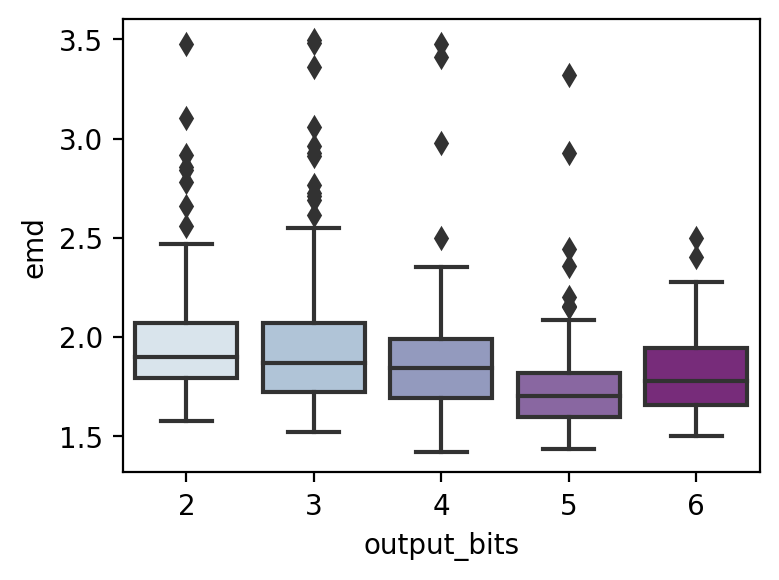

In [16]:
"""
Box plot EMD vs number of output_bits
"""
fig, ax = plt.subplots(figsize=(4, 3))
sns.boxplot(data=df, x="output_bits", y="emd", ax=ax, palette="BuPu")

fig.tight_layout()
plt.savefig("emd_v_output_bits_boxplot.pdf")
plt.savefig("emd_v_output_bits_boxplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


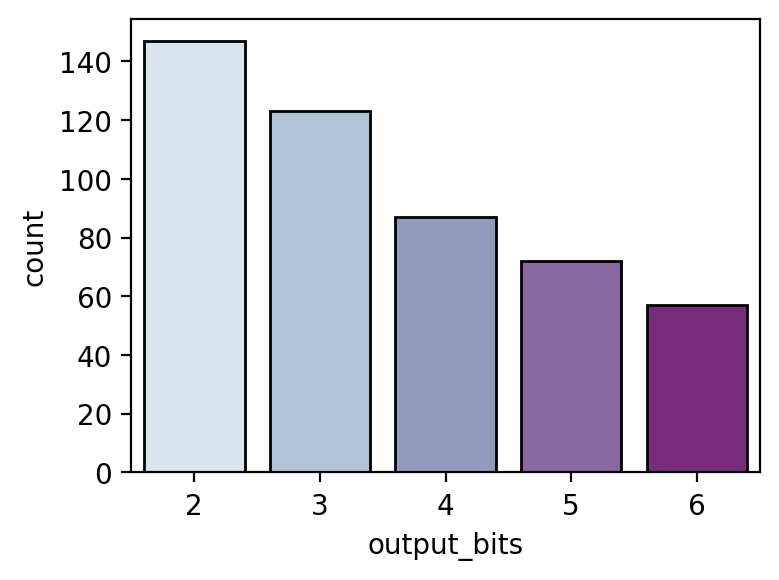

In [17]:
"""
Bar plot to count number of trials with a neural network with different number of output bits
"""
fig, ax = plt.subplots(figsize=(4, 3))

ax = sns.countplot(data=df, x="output_bits", ax=ax, palette="BuPu", edgecolor="k")

fig.tight_layout()
plt.savefig("output_bits_count.pdf")
plt.savefig("output_bits_count.png")

In [18]:
# TODO: Plot emd vs first/last layer width box plot


In [46]:
"""
Scatter plot avg EMD (over 3 random seeds) vs LUTCost
"""

df2 = df[df.duplicated("lut_cost", keep=False)].groupby("lut_cost")["emd"].apply(list).reset_index()
df2["avg_emd"] = df2["emd"].apply(np.mean)
df2 = df2.sort_values("emd", ignore_index=True)
df2

,lut_cost,emd,avg_emd
0,2140224.0,"[1.419, 1.468, 1.511]",1.466000
1,442768.0,"[1.434, 1.463, 1.463]",1.453333
2,621936.0,"[1.472, 1.486, 1.587]",1.515000
3,2887648.0,"[1.498, 1.61, 1.823]",1.643667
4,963728.0,"[1.515, 1.655, 1.755]",1.641667
...,...,...,...
157,175232.0,"[2.498, 2.976, 3.412]",2.962000
158,191072.0,"[2.559, 2.843, 3.477]",2.959667
159,286064.0,"[2.692, 2.767, 2.929]",2.796000
160,2304160.0,"[2.859, 2.919, 3.104]",2.960667


pareto rows: [  0   1  19  21  29  49  64  73 180 355]
[[2.140224e+06 1.419000e+00]
 [4.427680e+05 1.434000e+00]
 [3.901120e+05 1.550000e+00]
 [3.760000e+05 1.554000e+00]
 [3.327840e+05 1.573000e+00]
 [1.660320e+05 1.604000e+00]
 [6.217600e+04 1.628000e+00]
 [3.931200e+04 1.646000e+00]
 [1.510400e+04 1.774000e+00]
 [1.078400e+04 1.994000e+00]]
avg pareto rows: [  1  18  27  33  37  88 140]
[[4.42768000e+05 1.45333333e+00]
 [3.32784000e+05 1.63866667e+00]
 [1.66032000e+05 1.64133333e+00]
 [6.21760000e+04 1.69800000e+00]
 [3.93120000e+04 1.78600000e+00]
 [1.51040000e+04 1.83666667e+00]
 [1.07840000e+04 2.03566667e+00]]


/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

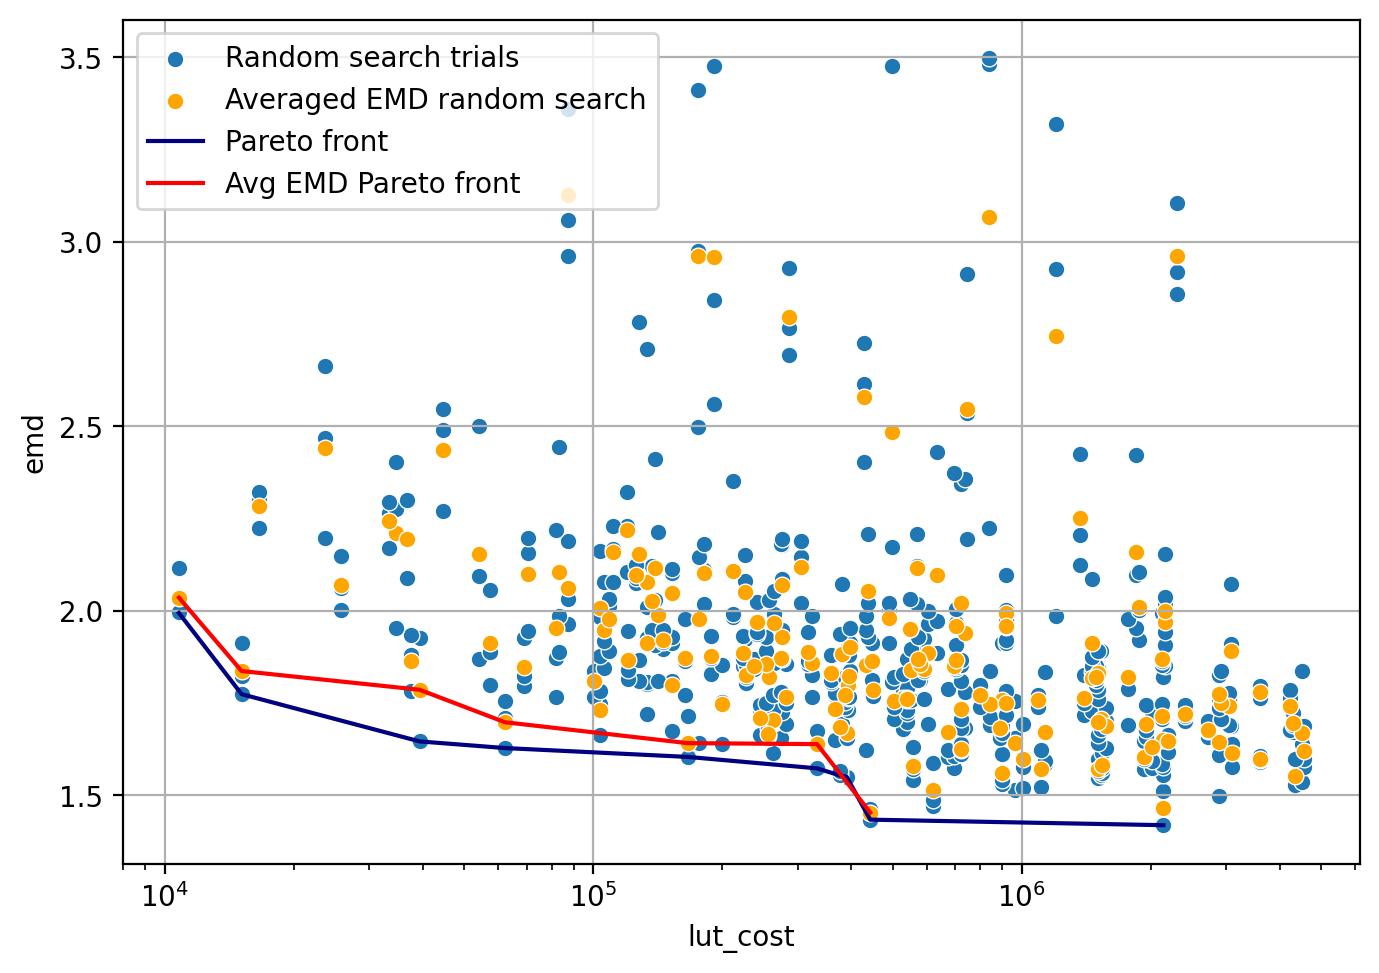

In [47]:
"""
Scatter plot EMD vs LUTCost
"""
def is_pareto_efficient(costs):
    """
    From: https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

# Pareto front for individual runs
costs = np.array(list(zip(df["lut_cost"], df["emd"])))
pareto_front_bool_array = is_pareto_efficient(costs)
print(f"pareto rows: {np.arange(len(costs))[pareto_front_bool_array]}")
pareto_front = costs[pareto_front_bool_array]
print(pareto_front)
pareto_lutcost = pareto_front[:, 0]
pareto_emd = pareto_front[:, 1]

# Pareto front for averaged runs (averaged emd across 3 random seeds) b/c each
# random search trial was run with 3 random seeds
# NOTE: Identify the models that form the average pareto front through searching by lutcost
avg_costs = np.array(list(zip(df2["lut_cost"], df2["avg_emd"])))
pareto_front_bool_array = is_pareto_efficient(avg_costs)
print(f"avg pareto rows: {np.arange(len(avg_costs))[pareto_front_bool_array]}")
avg_pareto_front = avg_costs[pareto_front_bool_array]
print(avg_pareto_front)
avg_pareto_lutcost = avg_pareto_front[:, 0]
avg_pareto_emd = avg_pareto_front[:, 1]

fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.scatterplot(data=df, x="lut_cost", y="emd", ax=ax, label="Random search trials")
ax = sns.scatterplot(data=df2, x="lut_cost", y="avg_emd", ax=ax, color="orange", label="Averaged EMD random search")

ax = sns.lineplot(x=pareto_lutcost, y=pareto_emd, ax=ax, color="navy", label="Pareto front")
ax = sns.lineplot(x=avg_pareto_lutcost, y=avg_pareto_emd, ax=ax, color="red", label="Avg EMD Pareto front")
# ax = sns.scatterplot(x=[pareto_lutcost[0]], y=[pareto_emd[0]], ax=ax, marker="X", color="cyan", label="Large model")
# ax = sns.scatterplot(x=[pareto_lutcost[1]], y=[pareto_emd[1]], ax=ax, marker="X", color="magenta", label="Medium model")
# ax = sns.scatterplot(x=[pareto_lutcost[2]], y=[pareto_emd[2]], ax=ax, marker="X", color="limegreen", label="Small model")


ax.legend()
ax.grid()
ax.set_xscale("log")

fig.tight_layout()
plt.savefig("emd_v_lutcost_scatterplot.pdf")
plt.savefig("emd_v_lutcost_scatterplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

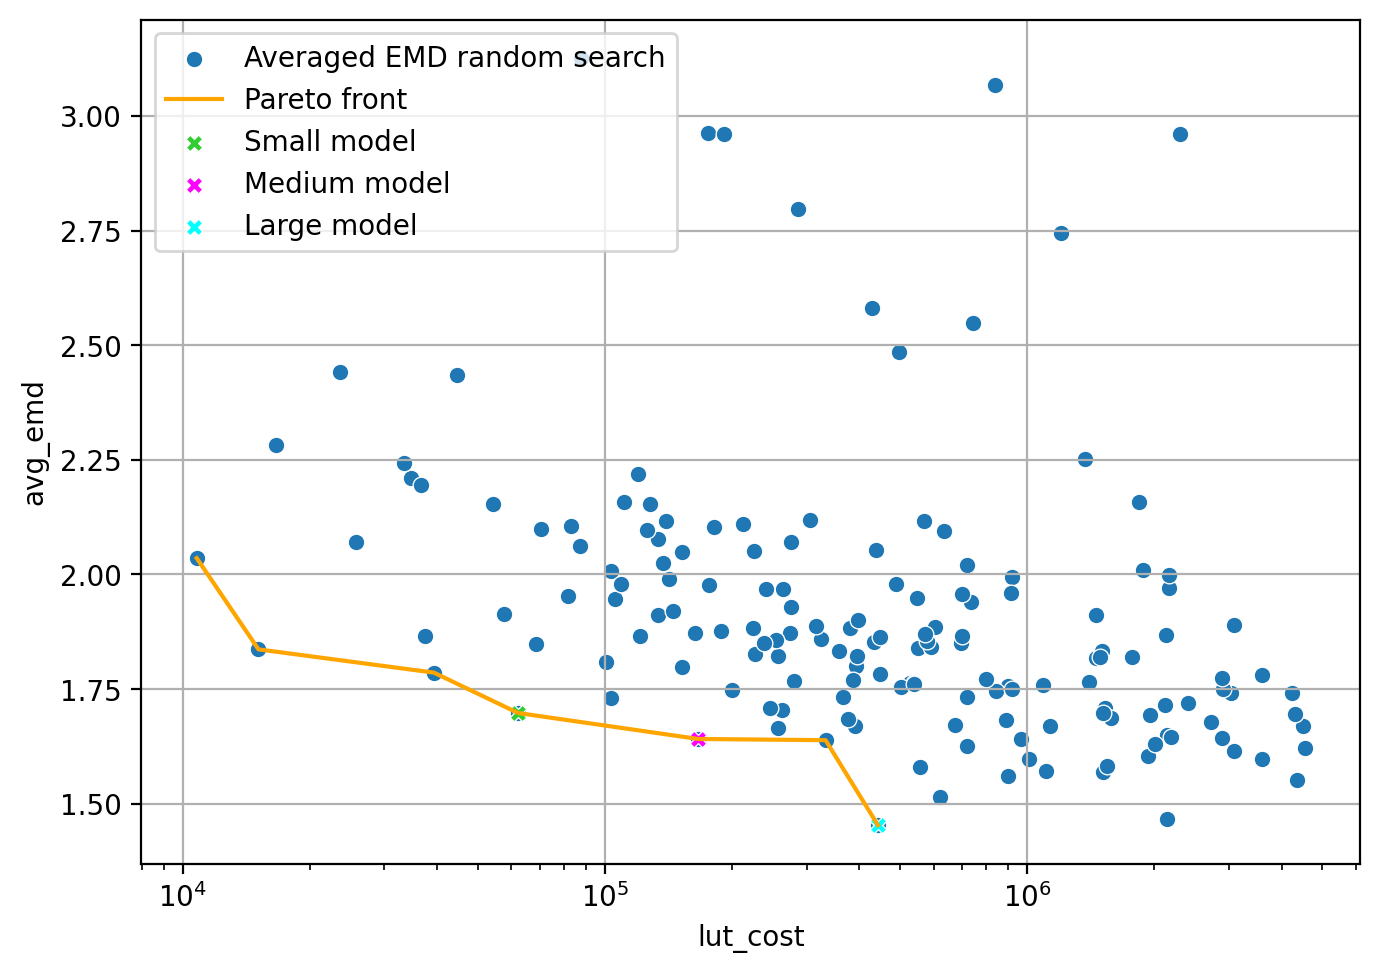

In [53]:
"""
Scatter plot avg EMD vs LUTCost
"""
fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.scatterplot(data=df2, x="lut_cost", y="avg_emd", ax=ax, label="Averaged EMD random search")

ax = sns.lineplot(x=avg_pareto_lutcost, y=avg_pareto_emd, ax=ax, color="orange", label="Pareto front")
ax = sns.scatterplot(x=[avg_pareto_lutcost[3]], y=[avg_pareto_emd[3]], ax=ax, marker="X", color="limegreen", label="Small model")
ax = sns.scatterplot(x=[avg_pareto_lutcost[2]], y=[avg_pareto_emd[2]], ax=ax, marker="X", color="magenta", label="Medium model")
ax = sns.scatterplot(x=[avg_pareto_lutcost[0]], y=[avg_pareto_emd[0]], ax=ax, marker="X", color="cyan", label="Large model")

ax.legend()
ax.grid()
ax.set_xscale("log")

fig.tight_layout()
plt.savefig("avg_emd_v_lutcost_scatterplot.pdf")
plt.savefig("avg_emd_v_lutcost_scatterplot.png")

## LogicNets Grid Search for Top 3 random search models
* Small model: `hparam19_2036987025`
    * hidden layers: `[256, 256]`
    * Random search EMD: 1.55
    * LUTCost: 390,112
* Medium model: `hparam17_432384445`
    * hidden layers: `[512; 512; 64]`
    * Random search EMD: 1.434
    * LUTCost: 442,768
* Large model: `hparam8_1916071045`
    * hidden layers: `[512; 256; 512; 512]`
    * Random search EMD: 1.419
    * LUTCost: 2,140,224

In [5]:
experiment_dir = "../sml_hp_grid_search/"
df = parse_grid_search_experiment(experiment_dir)
df

,trial,emd,loss,hidden_layers,act_bits,neuron_fanin,input_bits,input_fanin,output_bits,lr,lr_t0,wd,batch_size
0,large_lr0.001_warm_restart_freq50_wd0.0001_bat...,1.385,0.012,[512; 256; 512; 512],[3; 4; 6; 3],[5; 3; 2; 2],5,3,4,0.001,50,0.0001,512
1,large_lr0.001_warm_restart_freq100_wd0.01_batc...,1.400,0.011,[512; 256; 512; 512],[3; 4; 6; 3],[5; 3; 2; 2],5,3,4,0.001,100,0.0100,1024
2,large_lr0.001_warm_restart_freq50_wd0.01_batch...,1.404,0.012,[512; 256; 512; 512],[3; 4; 6; 3],[5; 3; 2; 2],5,3,4,0.001,50,0.0100,1024
3,medium_lr0.001_warm_restart_freq100_wd0.01_bat...,1.407,0.012,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.001,100,0.0100,512
4,large_lr0.001_warm_restart_freq100_wd0.01_batc...,1.414,0.012,[512; 256; 512; 512],[3; 4; 6; 3],[5; 3; 2; 2],5,3,4,0.001,100,0.0100,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,small_lr0.01_warm_restart_freq100_wd0.1_batch_...,1.730,0.022,[256; 256],[2; 6],[5; 2],5,3,6,0.010,100,0.1000,512
104,medium_lr0.01_warm_restart_freq50_wd0.1_batch_...,1.734,0.022,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.010,50,0.1000,512
105,small_lr0.01_warm_restart_freq50_wd0.1_batch_s...,1.742,0.022,[256; 256],[2; 6],[5; 2],5,3,6,0.010,50,0.1000,512
106,medium_lr0.01_warm_restart_freq100_wd0.1_batch...,1.747,0.024,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.010,100,0.1000,512


## LogicNets Grid Search for 3 Pareto models from random search 
(after averaging EMD across 3 random seeds per model)
* Small model: `hparam11_963241121`
    * hidden layers: `[128; 256; 128; 128]`
    * Random search avg EMD: 1.698
    * Random search best EMD: 1.628
    * Grid search best EMD: 1.589
    * Grid search best loss: 0.022
    * LUTCost: 62,176
* Medium model: `hparam18_524926359`
    * hidden layers: `[128; 256; 256; 256; 256; 128]`
    * Random search avg EMD: 1.641
    * Random search best EMD: 1.604
    * Grid search best EMD: 1.558
    * Grid search best loss: 0.027
    * LUTCost: 166,032
* Large model: `hparam17_432384445`
    * hidden layers: `[512; 512; 64]`
    * Random search avg EMD: 1.453
    * Random search best EMD: 1.434
    * Grid search best EMD: 1.407
    * Grid search best loss: 0.012
    * LUTCost: 442,768

In [96]:
BEST_SMALL_EMD = 1.589
BEST_MED_EMD = 1.558
BEST_LARGE_EMD = 1.407

experiment_dir = "../sml_avg_emd_hp_grid_search/"
df = parse_grid_search_experiment(experiment_dir)
df

,trial,emd,loss,hidden_layers,act_bits,neuron_fanin,input_bits,input_fanin,output_bits,lr,lr_t0,wd,batch_size
0,large_lr0.001_warm_restart_freq100_wd0.01_batc...,1.407,0.012,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.001,100,0.010,512
1,large_lr0.001_warm_restart_freq50_wd0.01_batch...,1.420,0.012,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.001,50,0.010,512
2,large_lr0.001_warm_restart_freq50_wd0.001_batc...,1.422,0.012,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.001,50,0.001,512
3,large_lr0.001_warm_restart_freq100_wd0.01_batc...,1.425,0.012,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.001,100,0.010,1024
4,large_lr0.001_warm_restart_freq50_wd0.001_batc...,1.451,0.013,[512; 512; 64],[3; 3; 4],[4; 5; 3],6,2,5,0.001,50,0.001,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,medium_lr0.01_warm_restart_freq100_wd0.01_batc...,2.330,0.065,[128; 256; 256; 256; 256; 128],[2; 2; 3; 4; 3; 4],[4; 6; 4; 2; 3; 2],4,2,5,0.010,100,0.010,512
133,small_lr0.01_warm_restart_freq50_wd0.01_batch_...,2.334,0.055,[128; 256; 128; 128],[2; 2; 2; 6],[6; 5; 4; 2],4,2,6,0.010,50,0.010,512
134,small_lr0.01_warm_restart_freq100_wd0.01_batch...,2.372,0.064,[128; 256; 128; 128],[2; 2; 2; 6],[6; 5; 4; 2],4,2,6,0.010,100,0.010,512
135,medium_lr0.01_warm_restart_freq50_wd0.01_batch...,2.516,0.066,[128; 256; 256; 256; 256; 128],[2; 2; 3; 4; 3; 4],[4; 6; 4; 2; 3; 2],4,2,5,0.010,50,0.010,512


## Weakest Pareto models from random search
(after averaging EMD across 3 random seeds per model)
* weak1 model: `hparam5_1665510883`
    * hidden layers: `[128; 128; 128]`
    * Random search avg EMD: 2.036
    * Random search best EMD: 1.994
    * Grid search best EMD: 1.913
    * Grid search best loss: 0.041
    * LUTCost: 10,684
* weak2 model: `hparam16_1583736550`
    * hidden layers: `[64; 128]`
    * Random search avg EMD: 1.837
    * Random search best EMD: 1.774
    * Grid search best EMD: 1.755
    * Grid search best loss: 0.034
    * LUTCost: 15,104

In [97]:
BEST_WEAK1_EMD = 1.913
BEST_WEAK2_EMD = 1.755

## Ensemble Learning results

In [98]:
def parse_ensembling_experiment(experiment_dir):
    """
    Parse ensemble learning experiment directory into dataframe
    """
    emd_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if "hparam" in single_run_dir:
            continue
        if os.path.isdir(single_run_dir):
            # Find emd file
            for f in os.listdir(single_run_dir):
                if "emd" in f:
                    emd_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,emd,loss,ensemble_size,model_size\n")
    for emd_f in emd_files:
        # Example emd file
        # averaging_medium_ensemble_size2_seed2_loss=0.011_emd.txt
        # Get EMD
        with open(emd_f, "r") as f:
            emd = float(f.readlines()[-1])
        trial = emd_f.split("/")[-2]
        # Get loss
        txt_file = emd_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        if "weak" in txt_file:
            ensemble_size = int(re.findall(f"\d+", txt_file)[1])
        else:
            ensemble_size = int(re.findall(f"\d+", txt_file)[0])
        if "small_fixed" in txt_file:
            model_size = "small_fixed"
        elif "medium_fixed" in txt_file:
            model_size = "medium_fixed"
        elif "large_fixed" in txt_file:
            model_size = "large_fixed"
        elif "small" in txt_file:
            model_size = "small"
        elif "medium_fr" in txt_file:
            model_size = 'medium_fr'
        elif "medium" in txt_file:
            model_size = "medium"
        elif "large" in txt_file:
            model_size = "large"
        elif "weak1_two_hundred_epochs" in txt_file:
            model_size = "weak1_200epochs"
        elif "weak1" in txt_file:
            model_size = "weak1"
        elif "weak2" in txt_file:
            model_size = "weak2"
        else:
            raise ValueError("No model size captured from logs")
        with open(results_file, "a") as f:
            f.write(f"{trial}, {emd:.3f}, {loss:.3f}, {ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("emd", ignore_index=True)
    df.to_csv(results_file, index=False)
    return df

## Averaging

In [99]:
experiment_dir = "../averaging"
df = parse_ensembling_experiment(experiment_dir)
best_single_model_large = {
    "trial": "best_single_model_large",
    "emd": 1.407,
    "loss": 0.012,
    "ensemble_size": 1,
    "model_size": "large",
}
best_single_model_medium = {
    "trial": "best_single_model_medium",
    "emd": 1.558,
    "loss": 0.03,
    "ensemble_size": 1,
    "model_size": "medium",
}
best_single_model_small = {
    "trial": "best_single_model_small",
    "emd": 1.589,
    "loss": 0.022,
    "ensemble_size": 1,
    "model_size": "small",
}
best_single_model_weak1 = {
    "trial": "best_single_model_weak1",
    "emd": 1.994,
    "loss": 0.043,
    "ensemble_size": 1,
    "model_size": "weak1",
}
best_single_model_large_df = pd.DataFrame(best_single_model_large, index=[0])
best_single_model_medium_df = pd.DataFrame(best_single_model_medium, index=[0])
best_single_model_small_df = pd.DataFrame(best_single_model_small, index=[0])
best_single_model_weak1_df = pd.DataFrame(best_single_model_weak1, index=[0])
df = pd.concat([df, best_single_model_large_df])
df = pd.concat([df, best_single_model_medium_df])
df = pd.concat([df, best_single_model_small_df])
df = pd.concat([df, best_single_model_weak1_df])
df = df.sort_values("emd", ignore_index=True)
averaging_df = df
df

,trial,emd,loss,ensemble_size,model_size
0,averaging_large_fixed_mask_ensemble_size16_seed2,1.128,0.006,16,large_fixed
1,averaging_large_fixed_mask_ensemble_size8_seed1,1.133,0.007,8,large_fixed
2,averaging_small_ensemble_size32_seed1,1.139,0.007,32,small
3,averaging_medium_ensemble_size32_seed1,1.153,0.007,32,medium
4,averaging_large_ensemble_size16_seed1,1.157,0.007,16,large
...,...,...,...,...,...
118,averaging_weak1_ensemble_size4_seed1665510883,1.981,0.031,4,weak1
119,best_single_model_weak1,1.994,0.043,1,weak1
120,averaging_medium_fixed_mask_ensemble_size2_seed1,2.009,0.035,2,medium_fixed
121,averaging_large_ensemble_size4_seed2,2.034,0.033,4,large


In [68]:
def group_df_by_model_size(df, single_model_emd, model_size="small"):
    avg_df = df[df["model_size"] == model_size]
    avg_df = avg_df[avg_df.duplicated("ensemble_size", keep=False)].groupby("ensemble_size")["emd"].apply(list).reset_index()
    avg_df["avg_emd"] = avg_df["emd"].apply(np.mean)
    avg_df["std_emd"] = avg_df["emd"].apply(np.std)
    avg_df["single_model_improvement"] = avg_df["emd"].apply(lambda emds: [round(single_model_emd / emd, 3) for emd in emds])
    avg_df["avg_single_model_improvement"] = avg_df["avg_emd"].apply(lambda x: single_model_emd / x)
    avg_df.loc[-1] = [1, [single_model_emd], single_model_emd, 0, [1], 1]
    print(f"{model_size} model")
    return avg_df

In [11]:
group_df_by_model_size(df, BEST_LARGE_EMD, model_size="large")

large model


,ensemble_size,emd,avg_emd,std_emd,single_model_improvement,avg_single_model_improvement
0,2,"[1.308, 1.34, 1.372]",1.340000,0.026128,"[1.076, 1.05, 1.026]",1.050000
1,4,"[1.247, 1.42, 2.034]",1.567000,0.337687,"[1.128, 0.991, 0.692]",0.897894
2,8,"[1.182, 1.185, 1.438]",1.268333,0.119979,"[1.19, 1.187, 0.978]",1.109330
3,16,"[1.157, 1.228, 1.33]",1.238333,0.071004,"[1.216, 1.146, 1.058]",1.136205
4,32,"[1.19, 1.374, 1.625]",1.396333,0.178289,"[1.182, 1.024, 0.866]",1.007639
-1,1,[1.407],1.407000,0.000000,[1],1.000000


In [12]:
group_df_by_model_size(df, BEST_MED_EMD, model_size="medium")

medium model


,ensemble_size,emd,avg_emd,std_emd,single_model_improvement,avg_single_model_improvement
0,2,"[1.507, 1.579, 1.67]",1.585333,0.066695,"[1.034, 0.987, 0.933]",0.982759
1,4,"[1.313, 1.327, 1.483]",1.374333,0.077051,"[1.187, 1.174, 1.051]",1.133641
2,8,"[1.248, 1.26, 1.269]",1.259000,0.008602,"[1.248, 1.237, 1.228]",1.237490
3,16,"[1.196, 1.218, 1.93]",1.448000,0.340944,"[1.303, 1.279, 0.807]",1.075967
4,32,"[1.153, 1.217, 1.311]",1.227000,0.064890,"[1.351, 1.28, 1.188]",1.269764
-1,1,[1.558],1.558000,0.000000,[1],1.000000


In [13]:
group_df_by_model_size(df, BEST_SMALL_EMD, model_size="small")

small model


,ensemble_size,emd,avg_emd,std_emd,single_model_improvement,avg_single_model_improvement
0,2,"[1.515, 1.519, 1.817]",1.617000,0.141431,"[1.049, 1.046, 0.875]",0.982684
1,4,"[1.409, 1.593, 1.601]",1.534333,0.088684,"[1.128, 0.997, 0.993]",1.035629
2,8,"[1.329, 1.353, 1.448]",1.376667,0.051383,"[1.196, 1.174, 1.097]",1.154237
3,16,"[1.271, 1.285, 1.344]",1.300000,0.031633,"[1.25, 1.237, 1.182]",1.222308
4,32,"[1.139, 1.285, 1.322]",1.248667,0.079004,"[1.395, 1.237, 1.202]",1.272557
-1,1,[1.589],1.589000,0.000000,[1],1.000000


In [14]:
group_df_by_model_size(df, BEST_WEAK1_EMD, model_size="weak1")

weak1 model


,ensemble_size,emd,avg_emd,std_emd,single_model_improvement,avg_single_model_improvement
0,2,"[1.807, 1.832, 1.876]",1.838333,0.028523,"[1.059, 1.044, 1.02]",1.040617
1,4,"[1.694, 1.777, 1.981]",1.817333,0.120588,"[1.129, 1.077, 0.966]",1.052641
2,8,"[1.673, 1.879, 1.919]",1.823667,0.107782,"[1.143, 1.018, 0.997]",1.048986
3,16,"[1.637, 1.655, 1.748]",1.680000,0.048642,"[1.169, 1.156, 1.094]",1.138690
4,32,"[1.567, 1.605, 1.714]",1.628667,0.062302,"[1.221, 1.192, 1.116]",1.174580
-1,1,[1.913],1.913000,0.000000,[1],1.000000


In [15]:
group_df_by_model_size(df, BEST_WEAK1_EMD, model_size="weak1_200epochs")

weak1_200epochs model


,ensemble_size,emd,avg_emd,std_emd,single_model_improvement,avg_single_model_improvement
0,2,"[1.76, 1.765, 1.876]",1.800333,0.053543,"[1.087, 1.084, 1.02]",1.062581
1,4,"[1.694, 1.751, 1.981]",1.808667,0.124060,"[1.129, 1.093, 0.966]",1.057685
2,8,"[1.673, 1.83]",1.751500,0.078500,"[1.143, 1.045]",1.092207
3,16,"[1.637, 1.655, 1.748]",1.680000,0.048642,"[1.169, 1.156, 1.094]",1.138690
4,32,"[1.567, 1.605, 1.714]",1.628667,0.062302,"[1.221, 1.192, 1.116]",1.174580
-1,1,[1.913],1.913000,0.000000,[1],1.000000


In [69]:
group_df_by_model_size(df, BEST_LARGE_EMD, model_size="large_fixed")

large_fixed model


,ensemble_size,emd,avg_emd,std_emd,single_model_improvement,avg_single_model_improvement
0,2,"[1.323, 1.455, 1.488]",1.422000,0.071288,"[1.063, 0.967, 0.946]",0.989451
1,4,"[1.284, 1.321, 1.527]",1.377333,0.106903,"[1.096, 1.065, 0.921]",1.021539
2,8,"[1.133, 1.212, 1.263]",1.202667,0.053481,"[1.242, 1.161, 1.114]",1.169900
3,16,"[1.128, 1.162, 1.185]",1.158333,0.023414,"[1.247, 1.211, 1.187]",1.214676
-1,1,[1.407],1.407000,0.000000,[1],1.000000


In [70]:
group_df_by_model_size(df, BEST_MED_EMD, model_size="medium_fixed")

medium_fixed model


,ensemble_size,emd,avg_emd,std_emd,single_model_improvement,avg_single_model_improvement
0,2,"[1.465, 1.548, 2.009]",1.674000,0.239292,"[1.063, 1.006, 0.776]",0.930705
1,4,"[1.313, 1.34, 2.115]",1.589333,0.371866,"[1.187, 1.163, 0.737]",0.980285
2,8,"[1.236, 1.281, 1.418]",1.311667,0.077401,"[1.261, 1.216, 1.099]",1.187802
3,16,"[1.276, 1.28, 1.297]",1.284333,0.009104,"[1.221, 1.217, 1.201]",1.213081
4,32,"[1.217, 1.361, 1.678]",1.418667,0.192569,"[1.28, 1.145, 0.928]",1.098214
-1,1,[1.558],1.558000,0.000000,[1],1.000000


In [100]:
group_df_by_model_size(df, BEST_SMALL_EMD, model_size="small_fixed")

small_fixed model


,ensemble_size,emd,avg_emd,std_emd,single_model_improvement,avg_single_model_improvement
0,2,"[1.455, 1.542, 1.564]",1.520333,0.047063,"[1.092, 1.03, 1.016]",1.045166
1,4,"[1.398, 1.442, 1.451]",1.430333,0.023156,"[1.137, 1.102, 1.095]",1.110930
2,8,"[1.319, 1.331, 1.462]",1.370667,0.064768,"[1.205, 1.194, 1.087]",1.159290
3,16,"[1.283, 1.328, 1.356]",1.322333,0.030070,"[1.239, 1.197, 1.172]",1.201664
4,32,"[1.271, 1.347, 1.588]",1.402000,0.135132,"[1.25, 1.18, 1.001]",1.133381
-1,1,[1.589],1.589000,0.000000,[1],1.000000


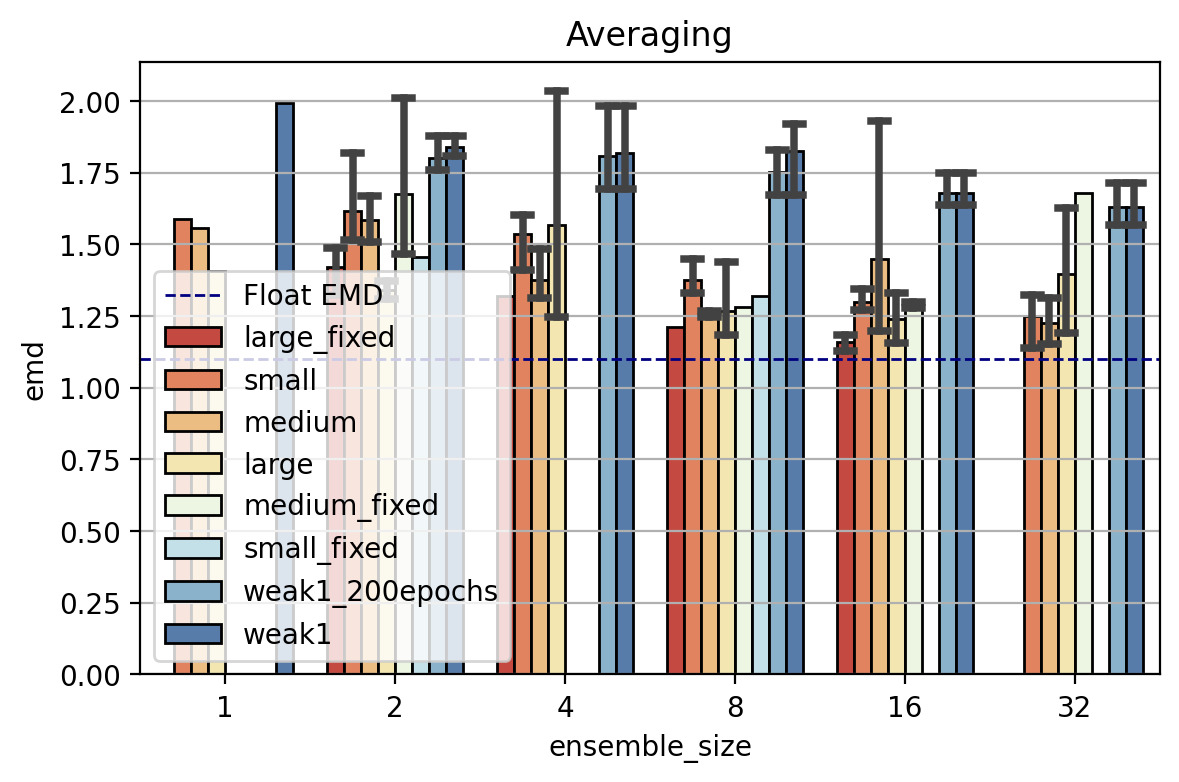

In [21]:
"""
Bar plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(6, 4))

ax.grid()
ax = sns.barplot(
    data=df, 
    x="ensemble_size", 
    y="emd", 
    ax=ax, 
    capsize=0.1, 
    palette="RdYlBu", 
    edgecolor="k", 
    hue="model_size",
)

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float EMD")

ax.legend()

ax.set_title("Averaging")

fig.tight_layout()
# plt.savefig("averaging_emd_v_ensemble_size_barplot.pdf")
# plt.savefig("averaging_emd_v_ensemble_size_barplot.png")

/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


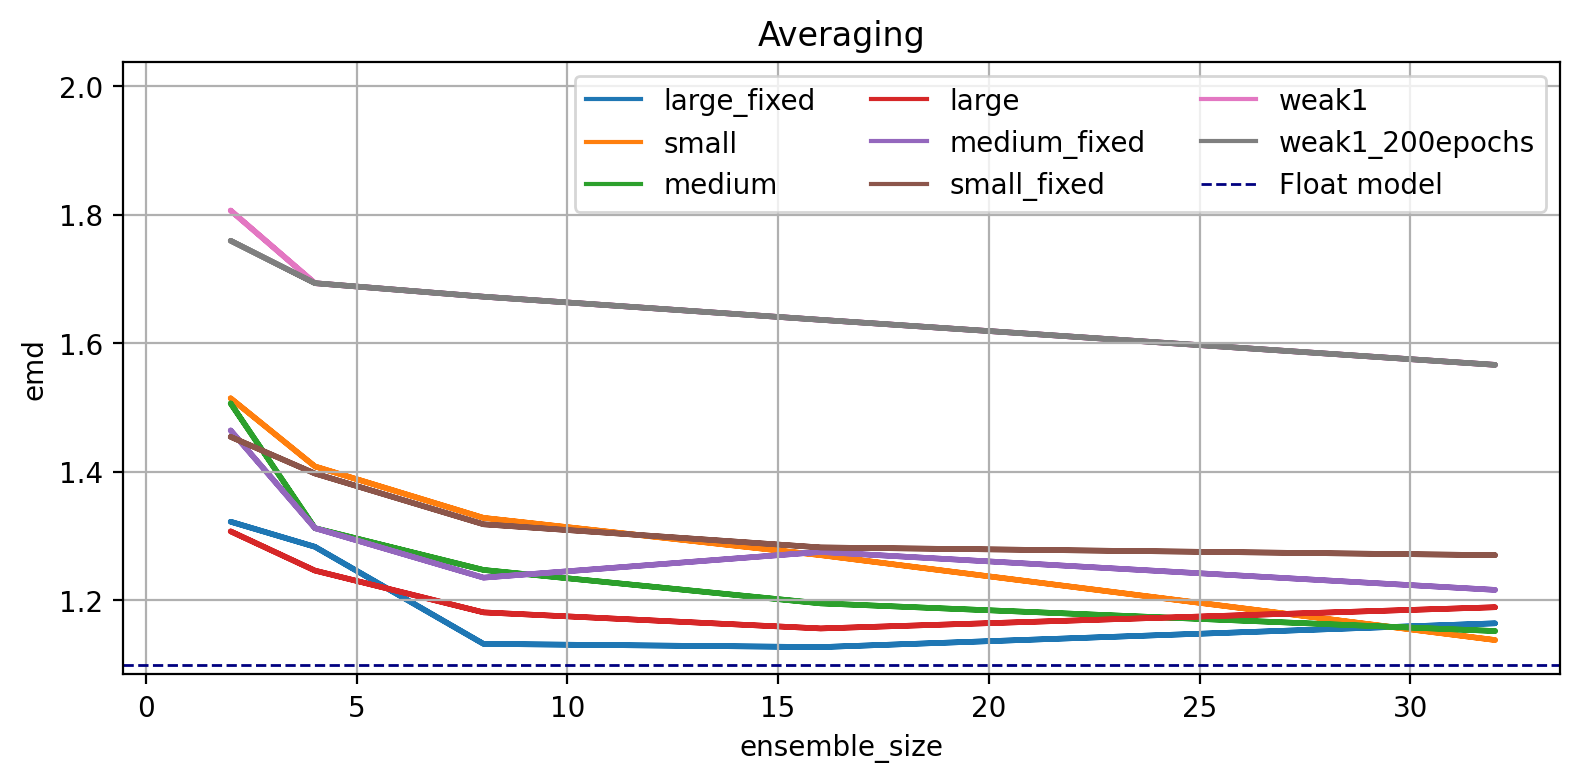

In [101]:
"""
Line plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(8, 4))

# TODO: Sort df by model size to get consistent colored lines per model size
# across ensemble methods

ax = sns.lineplot(
    data=df, 
    x="ensemble_size", 
    y="emd", 
    ax=ax, 
    hue="model_size", 
    errorbar=(lambda x: (x.min(), x.min())), 
    err_kws={"linewidth": 2, "alpha": 1}, 
    linewidth=2,
    alpha=0,
)

# Manually plot with matplotlib
# df_large = df[df["model_size"] == "large"]
# df_small = df[df["model_size"] == "small"]
# df_large = df_large.sort_values("ensemble_size")
# df_small = df_small.sort_values("ensemble_size")
# df2["avg_emd"] = df2["emd"].apply(np.mean)
# df2 = df2.sort_values("avg_emd", ignore_index=True)
# print(df_large)

# ax.plot(np.arange(len(df_large["ensemble_size"])), df_large["emd"], label="large")
# ax.plot(np.arange(len(df_large["ensemble_size"])), df_small["emd"], label="small")

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float model")

# ax.set_xticks(np.arange(len(set(df["ensemble_size"]))))
# ax.set_xticklabels(sorted(set(df["ensemble_size"])))

ax.grid()
ax.legend(ncol=3)
ax.set_title("Averaging")

fig.tight_layout()
# plt.savefig("averaging_emd_v_ensemble_size_fixed_mask_lineplot.pdf")
# plt.savefig("averaging_emd_v_ensemble_size_fixed_mask_lineplot.png")

In [102]:
def plot_random_vs_fixed_sparsity_masks(df, random_model_size, fixed_model_size):
    fig, ax = plt.subplots(figsize=(8, 4))

    df_random = df[df["model_size"] == random_model_size]
    df_fixed = df[df["model_size"] == fixed_model_size]
    df_random = df_random.sort_values("ensemble_size")
    df_fixed = df_fixed.sort_values("ensemble_size")
    df2 = pd.concat([df_random, df_fixed], ignore_index=True)
    # print(df2)

    ax = sns.lineplot(
        data=df2, 
        x="ensemble_size", 
        y="emd", 
        ax=ax, 
        hue="model_size", 
        errorbar=(lambda x: (x.min(), x.max())), 
        err_kws={"linewidth": 2, "alpha": 0.2}, 
        linewidth=2,
        alpha=1,
    )

    plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float model")
    ax.grid()
    ax.legend()
    ax.set_ylim([1.1, 2.1])
    ax.set_title("Averaging (Random vs fixed sparsity masks)")

    fig.tight_layout()
    plt.savefig(f"averaging_random_vs_fixed_{random_model_size}.png")
    plt.savefig(f"averaging_random_vs_fixed_{random_model_size}.pdf")


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


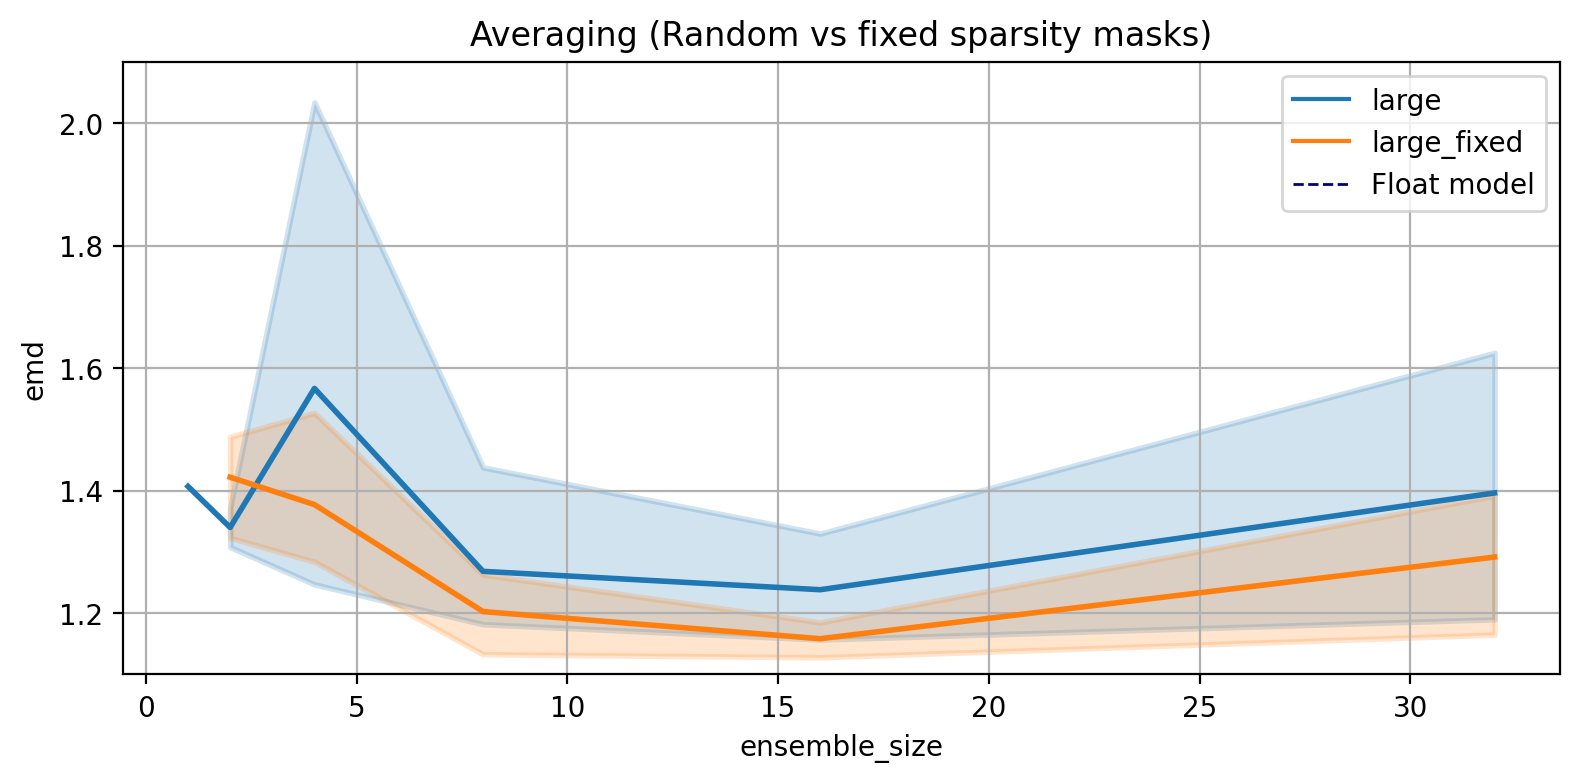

In [103]:
# Large vs Large fixed sparsity mask
plot_random_vs_fixed_sparsity_masks(df, "large", "large_fixed")


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


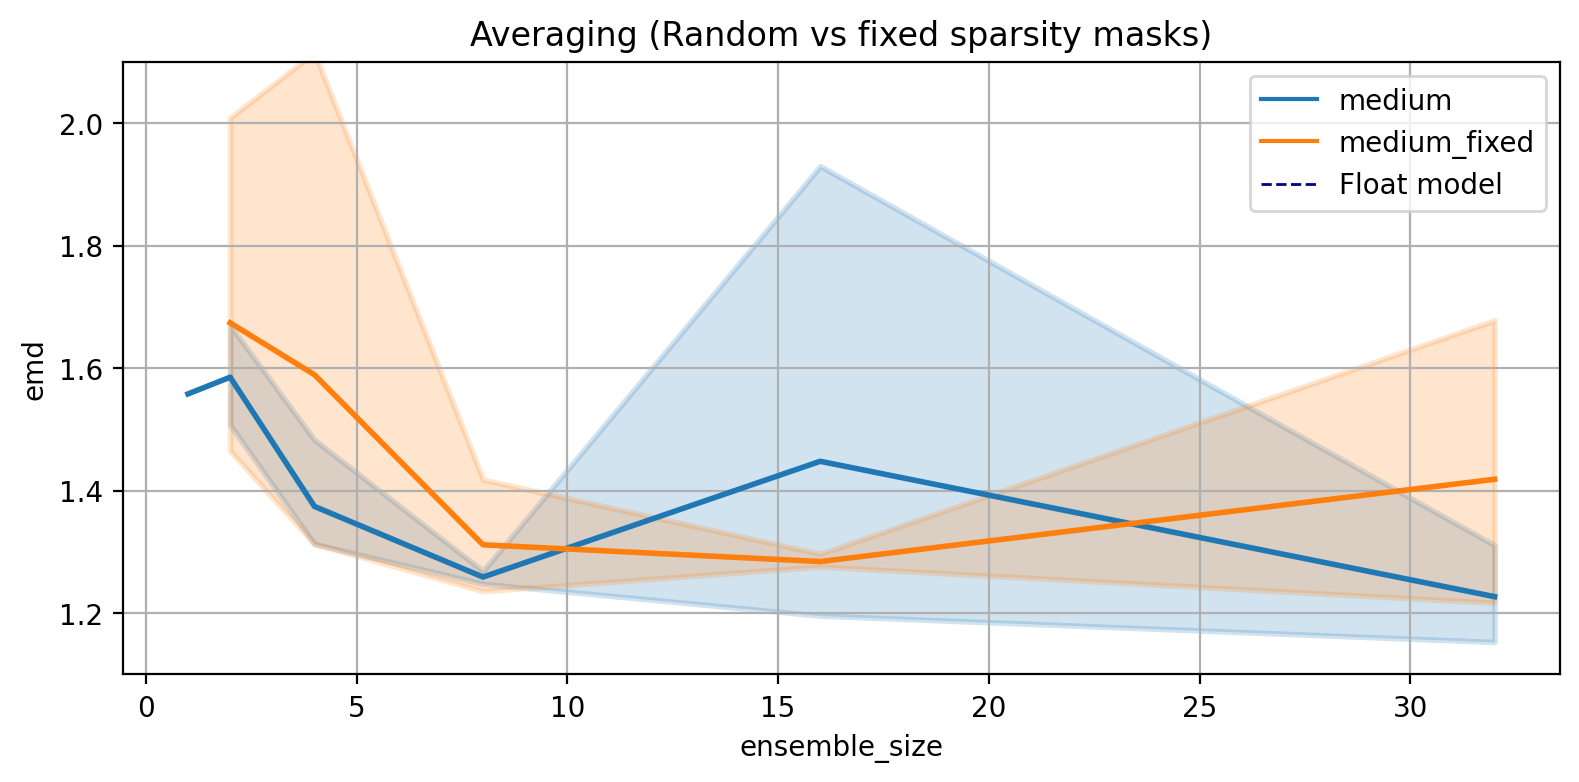

In [104]:
plot_random_vs_fixed_sparsity_masks(df, "medium", "medium_fixed")

/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


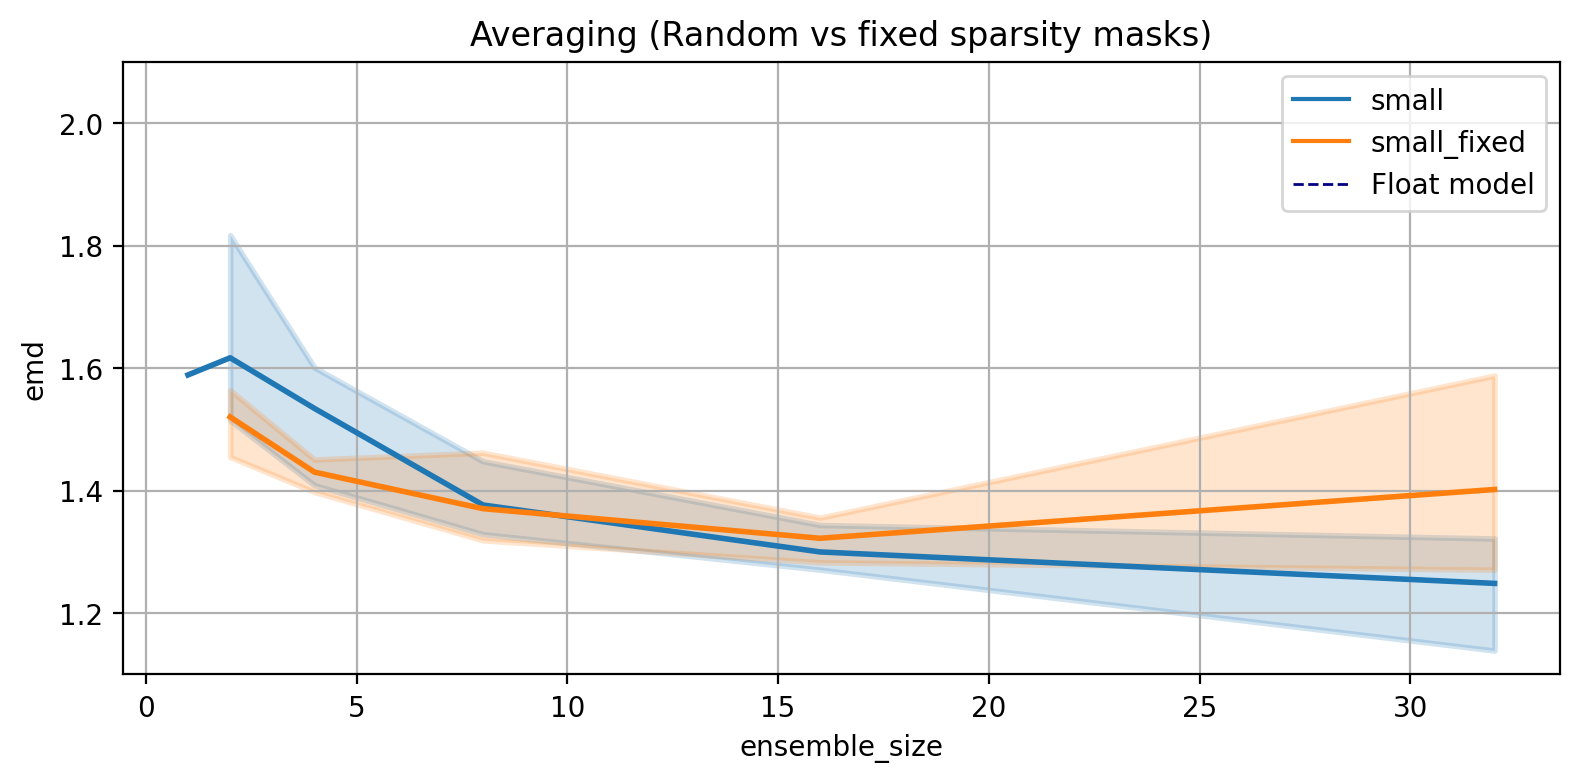

In [105]:
plot_random_vs_fixed_sparsity_masks(df, "small", "small_fixed")

## Snapshot Ensemble (SSE)

In [13]:
experiment_dir = "../sse"
df = parse_ensembling_experiment(experiment_dir)
best_single_model_large = {
    "trial": "best_single_model_large",
    "emd": 1.407,
    "loss": 0.012,
    "ensemble_size": 1,
    "model_size": "large",
}
best_single_model_medium = {
    "trial": "best_single_model_medium",
    "emd": 1.558,
    "loss": 0.03,
    "ensemble_size": 1,
    "model_size": "medium",
}
best_single_model_small = {
    "trial": "best_single_model_small",
    "emd": 1.589,
    "loss": 0.022,
    "ensemble_size": 1,
    "model_size": "small",
}
best_single_model_large_df = pd.DataFrame(best_single_model_large, index=[0])
best_single_model_medium_df = pd.DataFrame(best_single_model_medium, index=[0])
best_single_model_small_df = pd.DataFrame(best_single_model_small, index=[0])
df = pd.concat([df, best_single_model_large_df])
df = pd.concat([df, best_single_model_medium_df])
df = pd.concat([df, best_single_model_small_df])
df = df.sort_values("emd", ignore_index=True)
df

,trial,emd,loss,ensemble_size,model_size
0,best_single_model_large,1.407,0.012,1,large
1,best_single_model_medium,1.558,0.030,1,medium
2,best_single_model_small,1.589,0.022,1,small
3,sse_small_ensemble_size8,1.670,0.079,8,small
4,sse_large_ensemble_size2,1.675,0.020,2,large
5,sse_small_ensemble_size32,1.678,0.069,32,small
6,sse_small_ensemble_size2,1.686,0.035,2,small
7,sse_small_ensemble_size4,1.690,0.047,4,small
8,sse_large_ensemble_size4,1.750,0.019,4,large
9,sse_small_ensemble_size16,1.755,0.086,16,small


/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

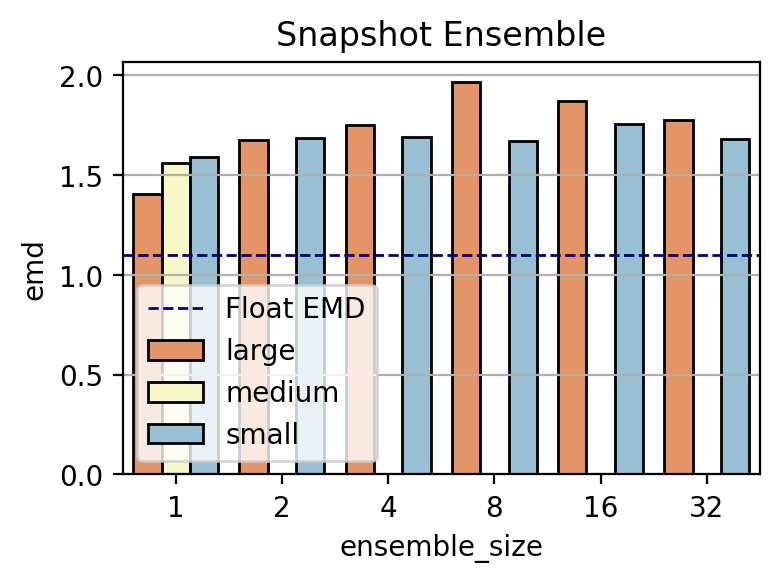

In [14]:
"""
Bar plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(4, 3))

ax.grid()
ax = sns.barplot(data=df, x="ensemble_size", y="emd", ax=ax, capsize=0.2, palette="RdYlBu", edgecolor="k", hue="model_size")

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float EMD")

ax.legend(loc="lower left")

ax.set_title("Snapshot Ensemble")

fig.tight_layout()
plt.savefig("sse_emd_v_ensemble_size_barplot.pdf")
plt.savefig("sse_emd_v_ensemble_size_barplot.png")

                        trial    emd   loss  ensemble_size model_size  \
0     best_single_model_large  1.407  0.012              1      large   
4    sse_large_ensemble_size2  1.675  0.020              2      large   
8    sse_large_ensemble_size4  1.750  0.019              4      large   
12   sse_large_ensemble_size8  1.968  0.024              8      large   
11  sse_large_ensemble_size16  1.871  0.022             16      large   
10  sse_large_ensemble_size32  1.778  0.021             32      large   

    ensemble_size_plot  
0                    0  
4                    1  
8                    2  
12                   3  
11                   4  
10                   5  


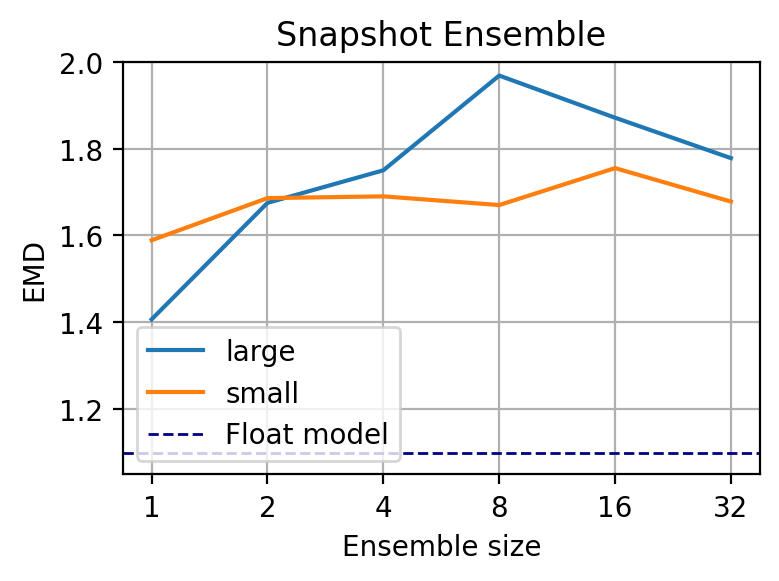

In [15]:
"""
Line plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(4, 3))

df["ensemble_size_plot"] = df["ensemble_size"].apply(lambda x: int(np.log2(x)))

# ax = sns.lineplot(data=df, x="ensemble_size_plot", y="emd", ax=ax, hue="model_size")

# Manually plot with matplotlib
df_large = df[df["model_size"] == "large"]
df_small = df[df["model_size"] == "small"]
df_large = df_large.sort_values("ensemble_size")
df_small = df_small.sort_values("ensemble_size")
# df2["avg_emd"] = df2["emd"].apply(np.mean)
# df2 = df2.sort_values("avg_emd", ignore_index=True)
print(df_large)

ax.plot(np.arange(len(df_large["ensemble_size"])), df_large["emd"], label="large")
ax.plot(np.arange(len(df_large["ensemble_size"])), df_small["emd"], label="small")

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float model")

ax.set_xticks(np.arange(len(set(df["ensemble_size"]))))
ax.set_xticklabels(sorted(set(df["ensemble_size"])))

ax.grid()
ax.legend()
ax.set_ylim([1.05, 2])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Snapshot Ensemble")

fig.tight_layout()
plt.savefig("sse_emd_v_ensemble_size_lineplot.pdf")
plt.savefig("sse_emd_v_ensemble_size_lineplot.png")

### SSE + decoder finetuning (5 epochs)

In [16]:
experiment_dir = "../sse_ft"
df = parse_ensembling_experiment(experiment_dir)
best_single_model_large = {
    "trial": "best_single_model_large",
    "emd": 1.407,
    "loss": 0.012,
    "ensemble_size": 1,
    "model_size": "large",
}
best_single_model_medium = {
    "trial": "best_single_model_medium",
    "emd": 1.558,
    "loss": 0.03,
    "ensemble_size": 1,
    "model_size": "medium",
}
best_single_model_small = {
    "trial": "best_single_model_small",
    "emd": 1.589,
    "loss": 0.022,
    "ensemble_size": 1,
    "model_size": "small",
}
best_single_model_large_df = pd.DataFrame(best_single_model_large, index=[0])
best_single_model_medium_df = pd.DataFrame(best_single_model_medium, index=[0])
best_single_model_small_df = pd.DataFrame(best_single_model_small, index=[0])
df = pd.concat([df, best_single_model_large_df])
df = pd.concat([df, best_single_model_medium_df])
df = pd.concat([df, best_single_model_small_df])
df = df.sort_values("emd", ignore_index=True)
sse_ft_df = df
df

,trial,emd,loss,ensemble_size,model_size
0,sse_large_ensemble_size32,1.279,0.008,32,large
1,sse_large_ensemble_size16,1.303,0.008,16,large
2,sse_large_ensemble_size4,1.346,0.010,4,large
3,sse_large_ensemble_size8,1.360,0.010,8,large
4,sse_large_ensemble_size2,1.370,0.011,2,large
5,best_single_model_large,1.407,0.012,1,large
6,sse_small_ensemble_size32,1.480,0.020,32,small
7,sse_small_ensemble_size16,1.493,0.020,16,small
8,sse_small_ensemble_size8,1.519,0.021,8,small
9,best_single_model_medium,1.558,0.030,1,medium


/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

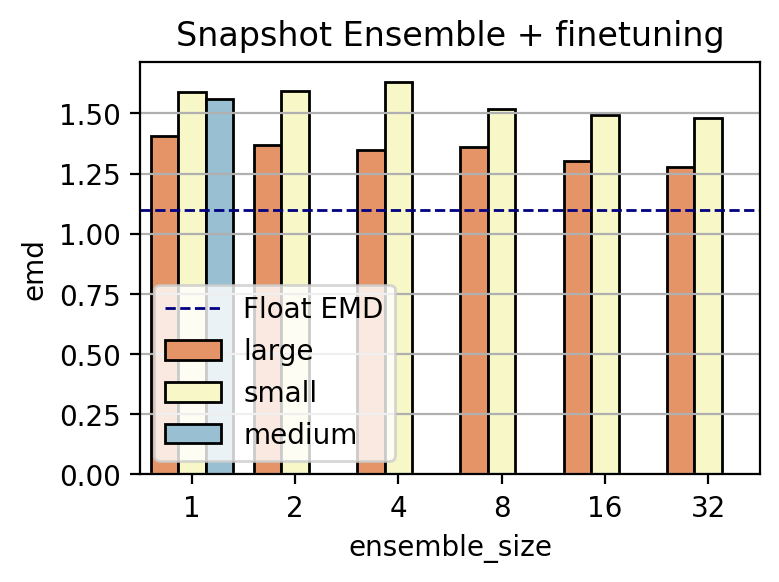

In [17]:
"""
Bar plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(4, 3))

ax.grid()
ax = sns.barplot(data=df, x="ensemble_size", y="emd", ax=ax, capsize=0.2, palette="RdYlBu", edgecolor="k", hue="model_size")

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float EMD")

ax.legend(loc="lower left")

ax.set_title("Snapshot Ensemble + finetuning")

fig.tight_layout()
plt.savefig("sse_ft_emd_v_ensemble_size_barplot.pdf")
plt.savefig("sse_ft_emd_v_ensemble_size_barplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

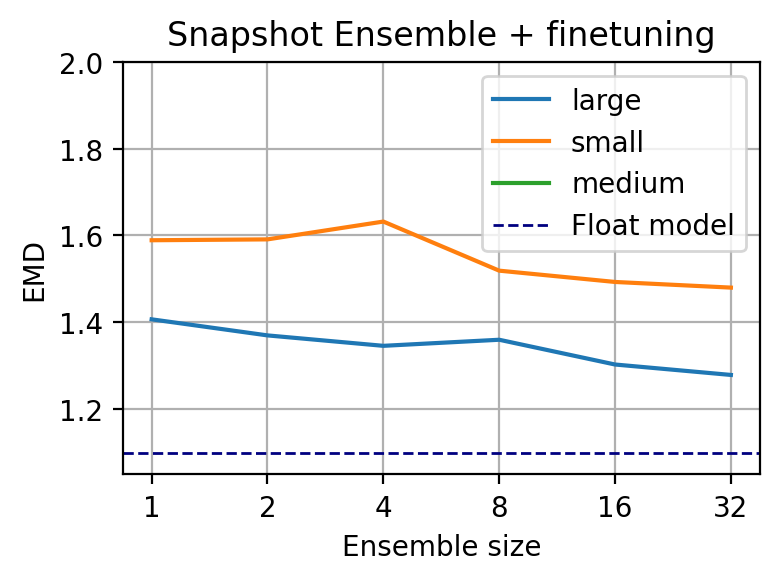

In [18]:
"""
Line plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(4, 3))

df["ensemble_size_plot"] = df["ensemble_size"].apply(lambda x: int(np.log2(x)))

ax = sns.lineplot(data=df, x="ensemble_size_plot", y="emd", ax=ax, hue="model_size")


# Manually plot with matplotlib
# df_large = df[df["model_size"] == "large"]
# df_small = df[df["model_size"] == "small"]
# df_large = df_large.sort_values("ensemble_size")
# df_small = df_small.sort_values("ensemble_size")
# # df2["avg_emd"] = df2["emd"].apply(np.mean)
# # df2 = df2.sort_values("avg_emd", ignore_index=True)
# print(df_large)

# ax.plot(np.arange(len(df_large["ensemble_size"])), df_large["emd"], label="large")
# ax.plot(np.arange(len(df_large["ensemble_size"])), df_small["emd"], label="small")

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float model")

ax.set_xticks(np.arange(len(set(df["ensemble_size"]))))
ax.set_xticklabels(sorted(set(df["ensemble_size"])))

ax.grid()
ax.legend()
ax.set_ylim([1.05, 2])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Snapshot Ensemble + finetuning")

fig.tight_layout()
plt.savefig("sse_ft_emd_v_ensemble_size_lineplot.pdf")
plt.savefig("sse_ft_emd_v_ensemble_size_lineplot.png")

### SSE + finetuning (10 epochs)
Here every member model was trained for minimum 50 epochs (ensemble_size = 16 & 32) or 100 epochs each (ensemble_size = 2, 4, 8) + 10 epochs of decoder finetuning

In [19]:
experiment_dir = "../sse_more_epochs"
df = parse_ensembling_experiment(experiment_dir)
best_single_model_large = {
    "trial": "best_single_model_large",
    "emd": 1.407,
    "loss": 0.012,
    "ensemble_size": 1,
    "model_size": "large",
}
best_single_model_medium = {
    "trial": "best_single_model_medium",
    "emd": 1.558,
    "loss": 0.03,
    "ensemble_size": 1,
    "model_size": "medium",
}
best_single_model_small = {
    "trial": "best_single_model_small",
    "emd": 1.589,
    "loss": 0.022,
    "ensemble_size": 1,
    "model_size": "small",
}
best_single_model_large_df = pd.DataFrame(best_single_model_large, index=[0])
best_single_model_medium_df = pd.DataFrame(best_single_model_medium, index=[0])
best_single_model_small_df = pd.DataFrame(best_single_model_small, index=[0])
df = pd.concat([df, best_single_model_large_df])
df = pd.concat([df, best_single_model_medium_df])
df = pd.concat([df, best_single_model_small_df])
df = df.sort_values("emd", ignore_index=True)
sse_more_epochs_df = df
df

,trial,emd,loss,ensemble_size,model_size
0,sse_large_ensemble_size8_seed432384445,1.296,0.010,8,large
1,sse_large_ensemble_size32_seed432384445,1.298,0.008,32,large
2,sse_large_ensemble_size32_seed1,1.300,0.008,32,large
3,sse_large_ensemble_size16_seed432384445,1.301,0.008,16,large
4,sse_large_ensemble_size8_seed1,1.304,0.008,8,large
5,sse_large_ensemble_size16_seed1,1.310,0.008,16,large
6,sse_large_ensemble_size4_seed1,1.322,0.009,4,large
7,sse_large_ensemble_size4_seed432384445,1.342,0.010,4,large
8,sse_medium_ensemble_size32_seed524926359,1.352,0.024,32,medium
9,sse_medium_ensemble_size16_seed524926359,1.354,0.023,16,medium


/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

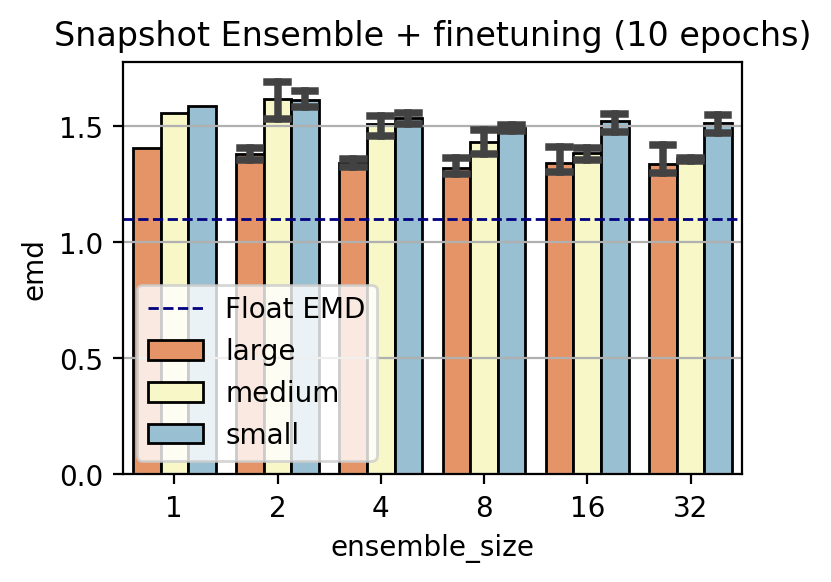

In [20]:
"""
Bar plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(4, 3))

ax.grid()
ax = sns.barplot(data=df, x="ensemble_size", y="emd", ax=ax, capsize=0.2, palette="RdYlBu", edgecolor="k", hue="model_size")

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float EMD")

ax.legend(loc="lower left")

ax.set_title("Snapshot Ensemble + finetuning (10 epochs)")

fig.tight_layout()
plt.savefig("sse_more_epochs_emd_v_ensemble_size_barplot.pdf")
plt.savefig("sse_more_epochs_emd_v_ensemble_size_barplot.png")

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

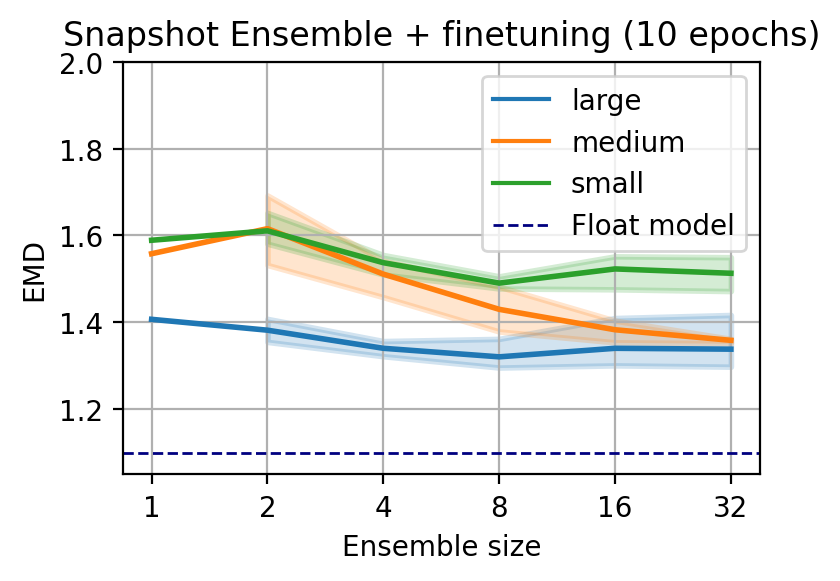

In [21]:
"""
Line plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(4, 3))

df["ensemble_size_plot"] = df["ensemble_size"].apply(lambda x: int(np.log2(x)))

ax = sns.lineplot(
    data=df, 
    x="ensemble_size_plot", 
    y="emd", 
    ax=ax, 
    hue="model_size",
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float model")

ax.set_xticks(np.arange(len(set(df["ensemble_size"]))))
ax.set_xticklabels(sorted(set(df["ensemble_size"])))

ax.grid()
ax.legend()
ax.set_ylim([1.05, 2])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Snapshot Ensemble + finetuning (10 epochs)")

fig.tight_layout()
plt.savefig("sse_more_epochs_emd_v_ensemble_size_lineplot.pdf")
plt.savefig("sse_more_epochs_emd_v_ensemble_size_lineplot.png")

## Fast Geometric Ensemble (FGE)

In [22]:
experiment_dir = "../fge"
df = parse_ensembling_experiment(experiment_dir)
best_single_model_large = {
    "trial": "best_single_model_large",
    "emd": 1.407,
    "loss": 0.012,
    "ensemble_size": 1,
    "model_size": "large",
}
best_single_model_medium = {
    "trial": "best_single_model_medium",
    "emd": 1.558,
    "loss": 0.03,
    "ensemble_size": 1,
    "model_size": "medium",
}
best_single_model_small = {
    "trial": "best_single_model_small",
    "emd": 1.589,
    "loss": 0.022,
    "ensemble_size": 1,
    "model_size": "small",
}
best_single_model_large_df = pd.DataFrame(best_single_model_large, index=[0])
best_single_model_medium_df = pd.DataFrame(best_single_model_medium, index=[0])
best_single_model_small_df = pd.DataFrame(best_single_model_small, index=[0])
df = pd.concat([df, best_single_model_large_df])
df = pd.concat([df, best_single_model_medium_df])
df = pd.concat([df, best_single_model_small_df])
df = df.sort_values("emd", ignore_index=True)
fge_df = df
df

,trial,emd,loss,ensemble_size,model_size
0,fge_large_ensemble_size32_seed1,1.304,0.009,32,large
1,fge_large_ensemble_size16_seed1,1.311,0.009,16,large
2,fge_large_ensemble_size32_seed432384445,1.311,0.010,32,large
3,fge_large_ensemble_size16_seed432384445,1.326,0.010,16,large
4,fge_large_ensemble_size8_seed1,1.329,0.009,8,large
5,fge_large_ensemble_size4_seed432384445,1.338,0.010,4,large
6,fge_large_ensemble_size8_seed432384445,1.348,0.010,8,large
7,fge_large_ensemble_size4_seed1,1.355,0.010,4,large
8,fge_large_ensemble_size2_seed1,1.373,0.010,2,large
9,fge_large_ensemble_size2_seed432384445,1.375,0.011,2,large


/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

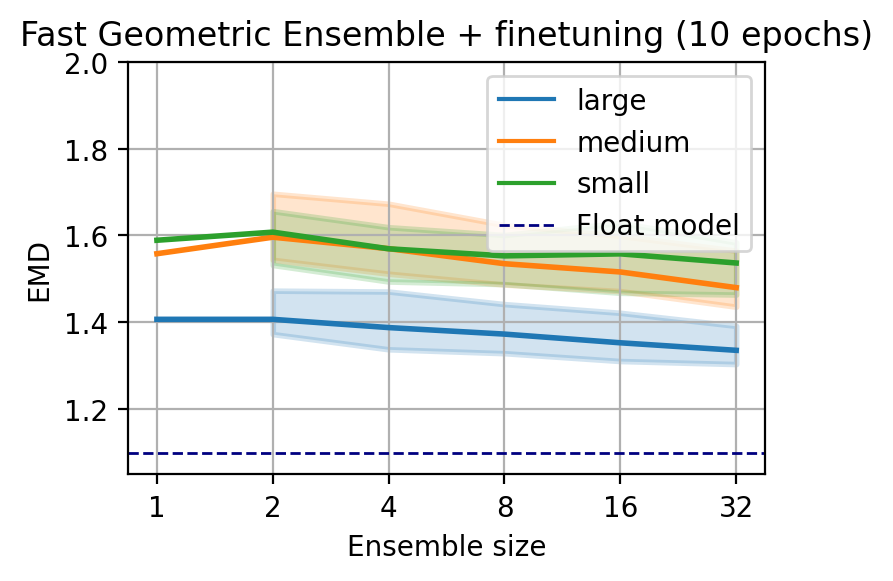

In [23]:
"""
Line plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(4, 3))

df["ensemble_size_plot"] = df["ensemble_size"].apply(lambda x: int(np.log2(x)))

ax = sns.lineplot(
    data=df, 
    x="ensemble_size_plot", 
    y="emd", 
    ax=ax, 
    hue="model_size",
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float model")

ax.set_xticks(np.arange(len(set(df["ensemble_size"]))))
ax.set_xticklabels(sorted(set(df["ensemble_size"])))

ax.grid()
ax.legend()
ax.set_ylim([1.05, 2])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Fast Geometric Ensemble + finetuning (10 epochs)")

fig.tight_layout()
plt.savefig("fge_emd_v_ensemble_size_lineplot.pdf")
plt.savefig("fge_emd_v_ensemble_size_lineplot.png")

## AdaBoost

In [106]:
def parse_seq_ensemble_exp(experiment_dir):
    """
    Parse sequentially trained ensemble learning experiment directory into
    dataframe
    """
    ensemble_perfs = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            for f in os.listdir(single_run_dir):
                if "ensemble_perf.txt" in f:
                    ensemble_perfs.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,emd,loss,ensemble_size,model_size\n")
    for ens_perf_f in ensemble_perfs:
        trial = ens_perf_f.split("/")[-2]
        if "test" in trial or "seq" not in trial: 
            continue
        # Get model size
        if "small" in trial:
            model_size = "small"
        elif "medium" in trial:
            model_size = "medium"
        elif "large" in trial:
            model_size = "large"
        elif "weak2" in trial:
            model_size = "weak2"
        elif "weak1" in trial:
            model_size = "weak1"
        # Get EMD, val loss, and ensemble size from ensemble_perf log
        with open(ens_perf_f, "r") as f:
            for l in f.readlines():
                if "Ensemble size" in l and "EMD" in l:
                    ensemble_size = re.findall(f"Ensemble size \d+", l)[0]
                    ensemble_size = int(re.findall(f"\d+", ensemble_size)[0])
                    # if ensemble_size == 1 or "-1" in l:
                    if "-1" in l:
                        continue 
                    loss = float(re.findall(f'\d+\.\d+', l)[0])
                    emd = float(re.findall(f'\d+\.\d+', l)[1])
                    with open(results_file, "a") as f:
                        f.write(f"{trial}, {emd:.3f}, {loss:.3f}, " \
                                f"{ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("emd", ignore_index=True)
    df.to_csv(results_file, index=False)
    return df

In [107]:
experiment_dir = "../adaboost"
df = parse_seq_ensemble_exp(experiment_dir)
best_single_model_large = {
    "trial": "best_single_model_large",
    "emd": 1.407,
    "loss": 0.012,
    "ensemble_size": 1,
    "model_size": "large",
}
best_single_model_medium = {
    "trial": "best_single_model_medium",
    "emd": 1.558,
    "loss": 0.03,
    "ensemble_size": 1,
    "model_size": "medium",
}
best_single_model_small = {
    "trial": "best_single_model_small",
    "emd": 1.589,
    "loss": 0.022,
    "ensemble_size": 1,
    "model_size": "small",
}
best_single_model_weak1 = {
    "trial": "best_single_model_weak1",
    "emd": BEST_WEAK1_EMD,
    "loss": 0.041,
    "ensemble_size": 1,
    "model_size": "weak1",
}
best_single_model_weak2 = {
    "trial": "best_single_model_weak2",
    "emd": BEST_WEAK2_EMD,
    "loss": 0.034,
    "ensemble_size": 1,
    "model_size": "weak2",
}
best_single_model_large_df = pd.DataFrame(best_single_model_large, index=[0])
best_single_model_medium_df = pd.DataFrame(best_single_model_medium, index=[0])
best_single_model_small_df = pd.DataFrame(best_single_model_small, index=[0])
best_single_model_weak1_df = pd.DataFrame(best_single_model_weak1, index=[0])
best_single_model_weak2_df = pd.DataFrame(best_single_model_weak2, index=[0])
df = pd.concat([df, best_single_model_large_df])
df = pd.concat([df, best_single_model_medium_df])
df = pd.concat([df, best_single_model_small_df])
df = pd.concat([df, best_single_model_weak1_df])
df = pd.concat([df, best_single_model_weak2_df])
df = df.sort_values("emd", ignore_index=True)
adaboost_df = df
df

,trial,emd,loss,ensemble_size,model_size
0,adaboost_large_seq_seed2,1.280,0.009,16,large
1,adaboost_large_seq_seed2,1.286,0.008,8,large
2,adaboost_large_seq_seed432384445,1.287,0.009,16,large
3,adaboost_large_seq_seed2,1.293,0.009,4,large
4,adaboost_large_seq_seed1,1.296,0.008,16,large
...,...,...,...,...,...
60,adaboost_weak1_seq_seed1,1.851,0.034,2,weak1
61,best_single_model_weak1,1.913,0.041,1,weak1
62,adaboost_weak2_seq_seed2,2.038,0.066,8,weak2
63,adaboost_weak2_seq_seed2,2.051,0.067,4,weak2


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


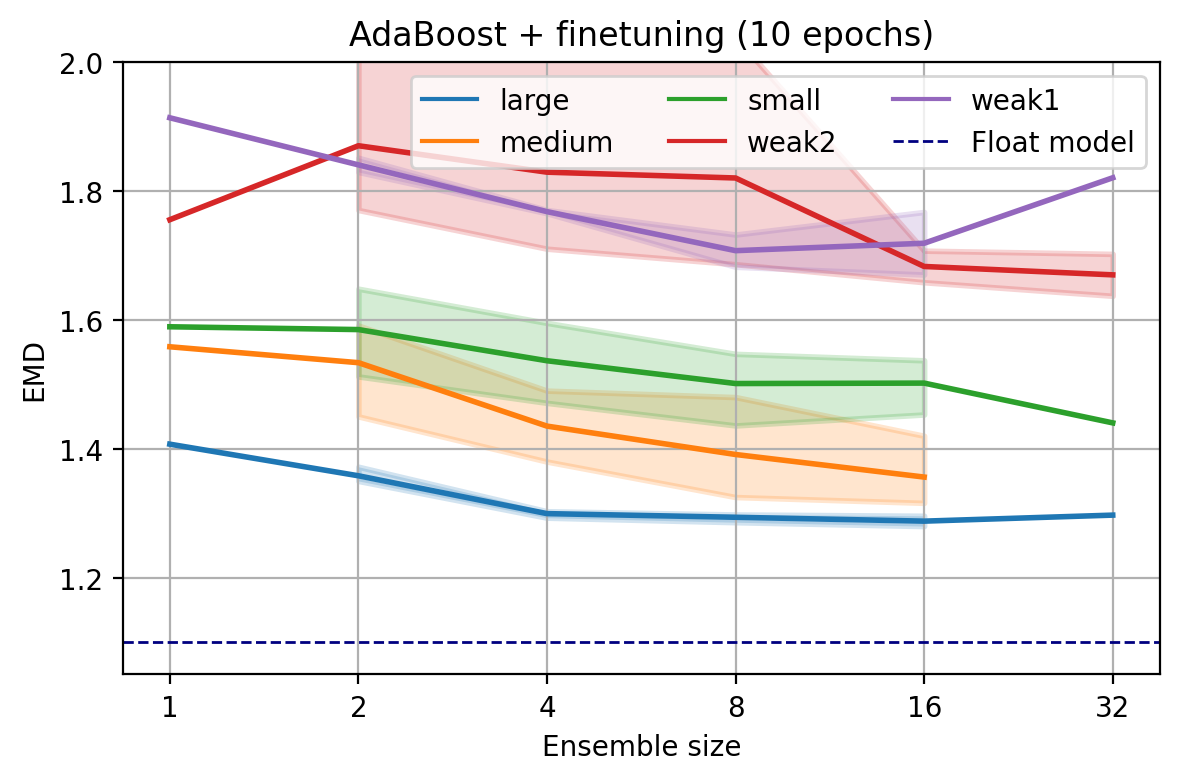

In [108]:
"""
Line plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(6, 4))

df["ensemble_size_plot"] = df["ensemble_size"].apply(lambda x: int(np.log2(x)))

ax = sns.lineplot(
    data=df, 
    x="ensemble_size_plot", 
    y="emd", 
    ax=ax, 
    hue="model_size",
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float model")

ax.set_xticks(np.arange(len(set(df["ensemble_size"]))))
ax.set_xticklabels(sorted(set(df["ensemble_size"])))

ax.grid()
ax.legend(ncol=3)
ax.set_ylim([1.05, 2])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("AdaBoost + finetuning (10 epochs)")

fig.tight_layout()
plt.savefig("adaboost_emd_v_ensemble_size_lineplot.pdf")
plt.savefig("adaboost_emd_v_ensemble_size_lineplot.png")

### AdaBoost Ablation Study

In [23]:
def parse_adaboost_ablation_exp(experiment_dir):
    """
    Parse adaboost ablation experiment directory into dataframe
    """
    ensemble_perfs = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            for f in os.listdir(single_run_dir):
                if "ensemble_perf.txt" in f:
                    ensemble_perfs.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "ablation_results.csv")
    with open(results_file, "w") as f:
        f.write("trial,emd,loss,ensemble_size,model_size\n")
    for ens_perf_f in ensemble_perfs:
        trial = ens_perf_f.split("/")[-2]
        if "test" in trial: 
            continue
        # Get model size
        if "small" in trial:
            model_size = "small"
        elif "medium" in trial:
            model_size = "medium"
        elif "large" in trial:
            model_size = "large"
        # Get EMD, val loss, and ensemble size from ensemble_perf log
        with open(ens_perf_f, "r") as f:
            for l in f.readlines():
                if "Single model 1" in l and "EMD" in l:
                    ensemble_size = 1
                    loss = float(re.findall(f'\d+\.\d+', l)[0])
                    emd = float(re.findall(f'\d+\.\d+', l)[1])
                    with open(results_file, "a") as f:
                        f.write(f"{trial}, {emd:.3f}, {loss:.3f}, " \
                                f"{ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("emd", ignore_index=True)
    df.to_csv(results_file, index=False)
    return df

In [123]:
experiment_dir = "../adaboost"
df = parse_adaboost_ablation_exp(experiment_dir)
best_single_model_large = {
    "trial": "best_single_model_large",
    "emd": 1.407,
    "loss": 0.012,
    "ensemble_size": 1,
    "model_size": "large",
}
best_single_model_medium = {
    "trial": "best_single_model_medium",
    "emd": 1.558,
    "loss": 0.03,
    "ensemble_size": 1,
    "model_size": "medium",
}
best_single_model_small = {
    "trial": "best_single_model_small",
    "emd": 1.589,
    "loss": 0.022,
    "ensemble_size": 1,
    "model_size": "small",
}
best_single_model_large_df = pd.DataFrame(best_single_model_large, index=[0])
best_single_model_medium_df = pd.DataFrame(best_single_model_medium, index=[0])
best_single_model_small_df = pd.DataFrame(best_single_model_small, index=[0])
df = pd.concat([df, best_single_model_large_df])
df = pd.concat([df, best_single_model_medium_df])
df = pd.concat([df, best_single_model_small_df])
df = df.sort_values("emd", ignore_index=True)
df

,trial,emd,loss,ensemble_size,model_size
0,best_single_model_large,1.407,0.012,1,large
1,adaboost_large_seq_seed432384445,1.445,0.013,1,large
2,adaboost_large_ind_decoder_seed432384445,1.445,0.013,1,large
3,best_single_model_medium,1.558,0.030,1,medium
4,adaboost_small_single_no_sampler_model,1.568,0.023,1,small
5,adaboost_medium_seq_seed524926359,1.578,0.027,1,medium
6,adaboost_medium_ind_decoder_seed524926359,1.578,0.027,1,medium
7,best_single_model_small,1.589,0.022,1,small
8,adaboost_small_seq_seed963241121,1.638,0.023,1,small
9,adaboost_small_ind_decoder_seed963241121,1.638,0.023,1,small


### Small model AdaBoost ablation study
| trial                                                | Sampler | Fixed Decoder | emd   | loss  | ensemble_size | model_size |
|------------------------------------------------------|:-------:|:-------------:|:-----:|:-----:|:-------------:|:----------:|
| adaboost_small_single_no_sampler_model               |         |               | 1.568 | 0.023 | 1             | small      |
| best_single_small_model (Grid search)                |         |               | 1.589 | 0.021 | 1             | small      |
| adaboost_small_ind_decoder_seed963241121             |    x    |               | 1.638 | 0.023 | 1             | small      |
| adaboost_small_seq_fixed_decoder_seed963241121       |    x    |      x        | 2.062 | 0.037 | 1             | small      |
| adaboost_small_single_no_sampler_fixed_decoder_model |         |      x        | 2.095 | 0.037 | 1             | small      |

### Medium model AdaBoost ablation study
| trial                                               | Sampler | Fixed Decoder |  emd  |  loss | ensemble_size | model_size |
|-----------------------------------------------------|:-------:|:-------------:|:-----:|:-----:|:-------------:|:----------:|
| best_single_medium_model (Grid search)              |         |               | 1.558 | 0.027 |       1       |   medium   |
| adaboost_medium_ind_decoder_seed524926359           |    x    |               | 1.578 | 0.027 |       1       |   medium   |
| adaboost_seq_medium_fixed_decoder_seed524926359     |    x    |      x        | 1.812 |  0.03 |       1       |   medium   |

### Large model AdaBoost ablation study
| trial                                                | Sampler | Fixed Decoder |  emd  |  loss | ensemble_size | model_size |
|------------------------------------------------------|:-------:|:-------------:|:-----:|:-----:|:-------------:|:----------:|
| best_single_large_model (Grid search)                |         |               | 1.407 | 0.012 |       1       |    large   |
| adaboost_large_ind_decoder_seed432384445             |    x    |               | 1.445 | 0.013 |       1       |    large   |
| adaboost_large_seq_fixed_decoder_seed432384445       |    x    |      x        | 2.153 | 0.038 |       1       |    large   |

### AdaBoost Fixed Mask Ablation Study

In [24]:
def parse_fixed_mask_ensemble_exp(experiment_dir):
    """
    Parse fixed sparsity mask ensemble learning experiment directory into
    dataframe
    """
    ensemble_perfs = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            for f in os.listdir(single_run_dir):
                if "ensemble_perf.txt" in f:
                    ensemble_perfs.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,emd,loss,ensemble_size,model_size\n")
    for ens_perf_f in ensemble_perfs:
        trial = ens_perf_f.split("/")[-2]
        if "seq" in trial or "fixed" in trial: 
            # Get model size
            if "small_fixed" in trial:
                model_size = "small_fixed"
            elif "medium_fixed" in trial:
                model_size = "medium_fixed"
            elif "large_fixed" in trial:
                model_size = "large_fixed"
            elif "small" in trial:
                model_size = "small"
            elif "medium" in trial:
                model_size = "medium"
            elif "large" in trial:
                model_size = "large"
            # Get EMD, val loss, and ensemble size from ensemble_perf log
            with open(ens_perf_f, "r") as f:
                for l in f.readlines():
                    if "Ensemble size" in l and "EMD" in l:
                        ensemble_size = re.findall(f"Ensemble size \d+", l)[0]
                        ensemble_size = int(re.findall(f"\d+", ensemble_size)[0])
                        # if ensemble_size == 1 or "-1" in l:
                        if "-1" in l:
                            continue 
                        loss = float(re.findall(f'\d+\.\d+', l)[0])
                        emd = float(re.findall(f'\d+\.\d+', l)[1])
                        with open(results_file, "a") as f:
                            f.write(f"{trial}, {emd:.3f}, {loss:.3f}, " \
                                    f"{ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("emd", ignore_index=True)
    df.to_csv(results_file, index=False)
    return df

In [80]:
experiment_dir = "../adaboost"
df = parse_fixed_mask_ensemble_exp(experiment_dir)
best_single_model_large = {
    "trial": "best_single_model_large",
    "emd": 1.407,
    "loss": 0.012,
    "ensemble_size": 1,
    "model_size": "large",
}
best_single_model_medium = {
    "trial": "best_single_model_medium",
    "emd": 1.558,
    "loss": 0.03,
    "ensemble_size": 1,
    "model_size": "medium",
}
best_single_model_small = {
    "trial": "best_single_model_small",
    "emd": 1.589,
    "loss": 0.022,
    "ensemble_size": 1,
    "model_size": "small",
}
best_single_model_large_df = pd.DataFrame(best_single_model_large, index=[0])
best_single_model_medium_df = pd.DataFrame(best_single_model_medium, index=[0])
best_single_model_small_df = pd.DataFrame(best_single_model_small, index=[0])
df = pd.concat([df, best_single_model_large_df])
df = pd.concat([df, best_single_model_medium_df])
df = pd.concat([df, best_single_model_small_df])
df = df.sort_values("emd", ignore_index=True)
df

,trial,emd,loss,ensemble_size,model_size
0,adaboost_large_seq_seed2,1.280,0.009,16,large
1,adaboost_large_seq_seed2,1.286,0.008,8,large
2,adaboost_large_seq_seed432384445,1.287,0.009,16,large
3,adaboost_large_seq_seed2,1.293,0.009,4,large
4,adaboost_large_seq_seed1,1.296,0.008,16,large
...,...,...,...,...,...
126,adaboost_weak1_seq_seed1665510883,1.829,0.033,2,medium_fixed
127,adaboost_weak1_seq_seed1,1.851,0.034,2,medium
128,adaboost_medium_fixed_mask_10epochs_seed524926359,1.881,0.037,2,medium_fixed
129,adaboost_medium_fixed_mask_10epochs_seed2,1.995,0.040,2,medium_fixed


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


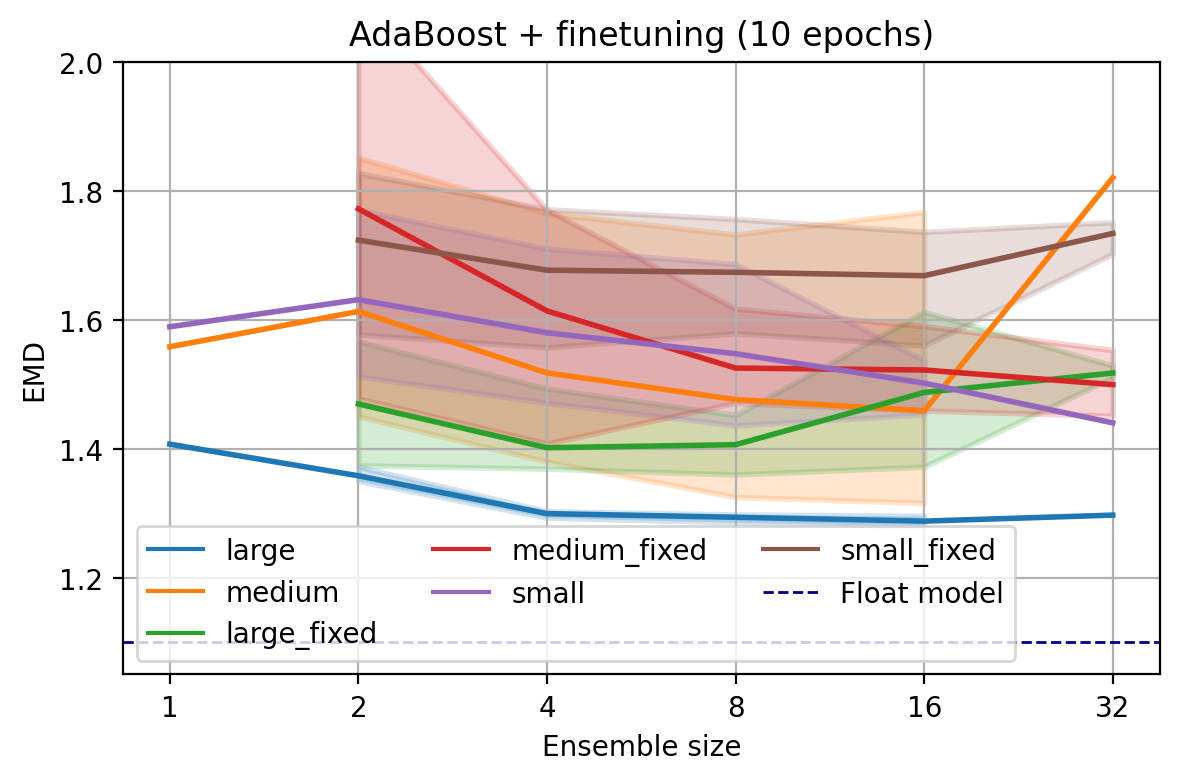

In [81]:
"""
Line plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(6, 4))

df["ensemble_size_plot"] = df["ensemble_size"].apply(lambda x: int(np.log2(x)))

ax = sns.lineplot(
    data=df, 
    x="ensemble_size_plot", 
    y="emd", 
    ax=ax, 
    hue="model_size",
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float model")

ax.set_xticks(np.arange(len(set(df["ensemble_size"]))))
ax.set_xticklabels(sorted(set(df["ensemble_size"])))

ax.grid()
ax.legend(loc="lower left", ncol=3)
ax.set_ylim([1.05, 2])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("AdaBoost + finetuning (10 epochs)")

fig.tight_layout()
plt.savefig("adaboost_emd_v_ensemble_size_fixed_mask_lineplot.pdf")
plt.savefig("adaboost_emd_v_ensemble_size_fixed_mask_lineplot.png")

## Bagging

In [10]:
experiment_dir = "../bagging"
df = parse_seq_ensemble_exp(experiment_dir)
best_single_model_large = {
    "trial": "best_single_model_large",
    "emd": 1.407,
    "loss": 0.012,
    "ensemble_size": 1,
    "model_size": "large",
}
best_single_model_medium = {
    "trial": "best_single_model_medium",
    "emd": 1.558,
    "loss": 0.03,
    "ensemble_size": 1,
    "model_size": "medium",
}
best_single_model_small = {
    "trial": "best_single_model_small",
    "emd": 1.589,
    "loss": 0.022,
    "ensemble_size": 1,
    "model_size": "small",
}
best_single_model_large_df = pd.DataFrame(best_single_model_large, index=[0])
best_single_model_medium_df = pd.DataFrame(best_single_model_medium, index=[0])
best_single_model_small_df = pd.DataFrame(best_single_model_small, index=[0])
df = pd.concat([df, best_single_model_large_df])
df = pd.concat([df, best_single_model_medium_df])
df = pd.concat([df, best_single_model_small_df])
df = df.sort_values("emd", ignore_index=True)
bagging_df = df
df

,trial,emd,loss,ensemble_size,model_size
0,bagging_large_seq_seed432384445,1.339,0.009,16,large
1,bagging_large_seq_seed1,1.352,0.009,16,large
2,bagging_large_seq_seed2,1.379,0.011,16,large
3,best_single_model_large,1.407,0.012,1,large
4,bagging_medium_seq_seed1,1.425,0.020,16,medium
5,bagging_large_seq_seed432384445,1.425,0.011,8,large
6,bagging_large_seq_seed1,1.425,0.011,8,large
7,bagging_large_seq_seed2,1.447,0.013,8,large
8,bagging_medium_seq_seed524926359,1.453,0.023,16,medium
9,bagging_medium_seq_seed2,1.472,0.025,16,medium


/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

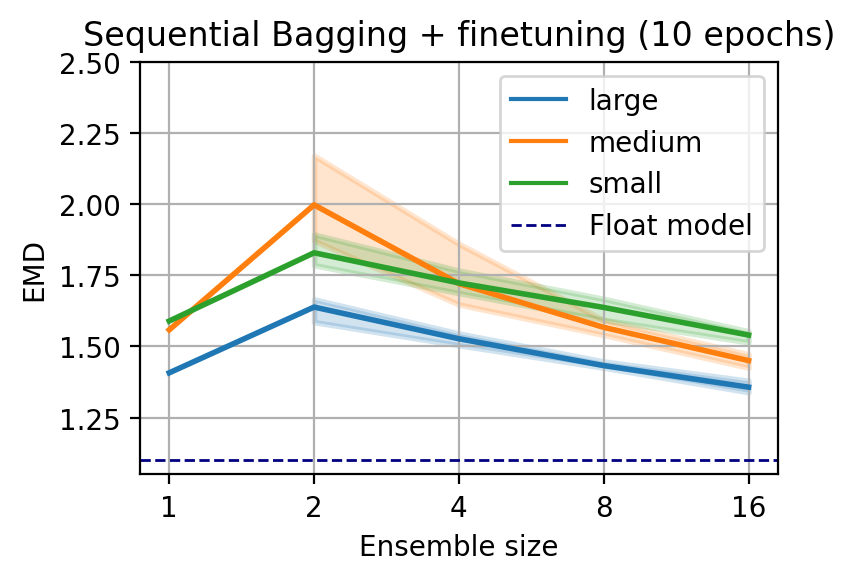

In [11]:
"""
Line plot of EMD vs ensemble size
"""
fig, ax = plt.subplots(figsize=(4, 3))

df["ensemble_size_plot"] = df["ensemble_size"].apply(lambda x: int(np.log2(x)))

ax = sns.lineplot(
    data=df, 
    x="ensemble_size_plot", 
    y="emd", 
    ax=ax, 
    hue="model_size",
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=1.1, linewidth=1, linestyle="--", color="navy", label="Float model")

ax.set_xticks(np.arange(len(set(df["ensemble_size"]))))
ax.set_xticklabels(sorted(set(df["ensemble_size"])))

ax.grid()
ax.legend()
ax.set_ylim([1.05, 2.5])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Sequential Bagging + finetuning (10 epochs)")

fig.tight_layout()
plt.savefig("bagging_emd_v_ensemble_size_lineplot.pdf")
plt.savefig("bagging_emd_v_ensemble_size_lineplot.png")

## Ensembling Comparison

In [35]:
averaging_df["ensemble_method"] = averaging_df["model_size"].apply(lambda x: "Averaging")
sse_ft_df["ensemble_method"] = sse_ft_df["model_size"].apply(lambda x: "SSE")
sse_more_epochs_df["ensemble_method"] = sse_more_epochs_df["model_size"].apply(lambda x: "SSE (more epochs)")
fge_df["ensemble_method"] = fge_df["model_size"].apply(lambda x: "FGE")
adaboost_df["ensemble_method"] = adaboost_df["model_size"].apply(lambda x: "AdaBoost")
bagging_df["ensemble_method"] = bagging_df["model_size"].apply(lambda x: "Bagging")
all_df = pd.concat([averaging_df, sse_ft_df])
all_df = pd.concat([all_df, sse_more_epochs_df])
all_df = pd.concat([all_df, fge_df])
all_df = pd.concat([all_df, adaboost_df])
all_df = pd.concat([all_df, bagging_df])
all_df

,trial,emd,loss,ensemble_size,model_size,ensemble_method,ensemble_size_plot
0,averaging_small_ensemble_size32_seed1,1.139,0.007,32,small,Averaging,NaN
1,averaging_medium_ensemble_size32_seed1,1.153,0.007,32,medium,Averaging,NaN
2,averaging_large_ensemble_size16_seed1,1.157,0.007,16,large,Averaging,NaN
3,averaging_large_ensemble_size8_seed2,1.182,0.007,8,large,Averaging,NaN
4,averaging_large_ensemble_size8_seed432384445,1.185,0.007,8,large,Averaging,NaN
...,...,...,...,...,...,...,...
34,bagging_medium_seq_seed2,1.860,0.037,4,medium,Bagging,2.0
35,bagging_medium_seq_seed1,1.871,0.030,2,medium,Bagging,1.0
36,bagging_small_seq_seed1,1.893,0.032,2,small,Bagging,1.0
37,bagging_medium_seq_seed524926359,1.950,0.039,2,medium,Bagging,1.0


/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

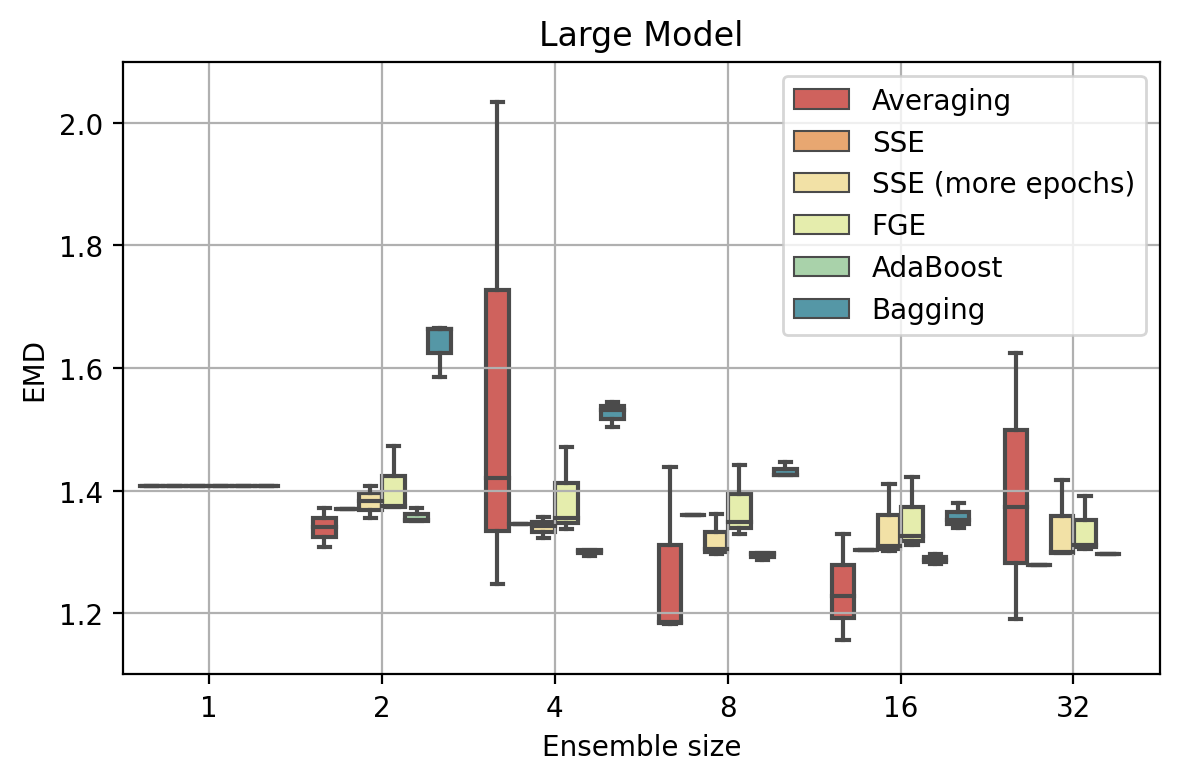

In [36]:
"""
Boxplot comparing all methods (Large model)
"""
fig, ax = plt.subplots(figsize=(6, 4))

large_df = all_df[all_df["model_size"] == "large"]

ax = sns.boxplot(data=large_df, x="ensemble_size", y="emd", hue="ensemble_method", palette="Spectral")

ax.grid()
ax.legend()
ax.set_ylim([1.1, 2.1])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Large Model")

fig.tight_layout()

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

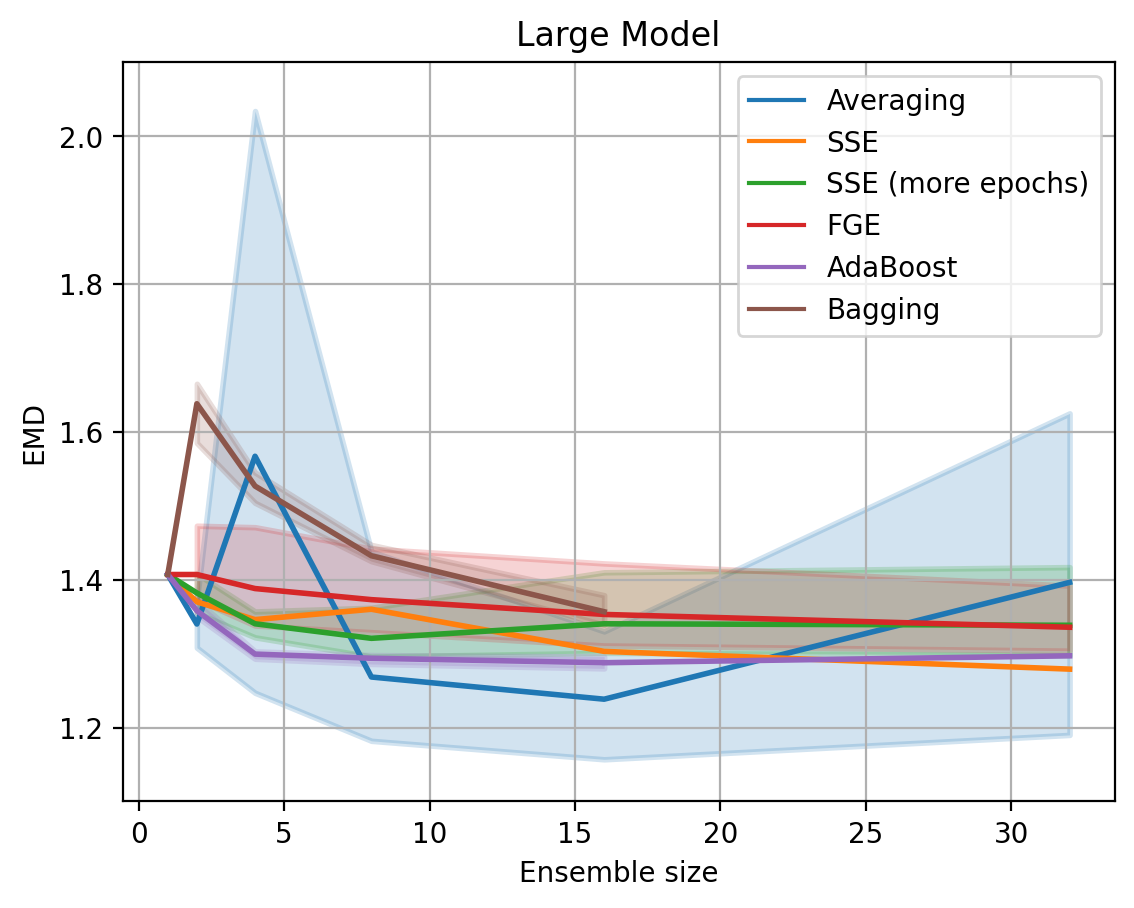

In [37]:
ax = sns.lineplot(
    data=large_df, 
    x="ensemble_size", 
    y="emd", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

ax.grid()
ax.legend()
ax.set_ylim([1.1, 2.1])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Large Model")

fig.tight_layout()

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

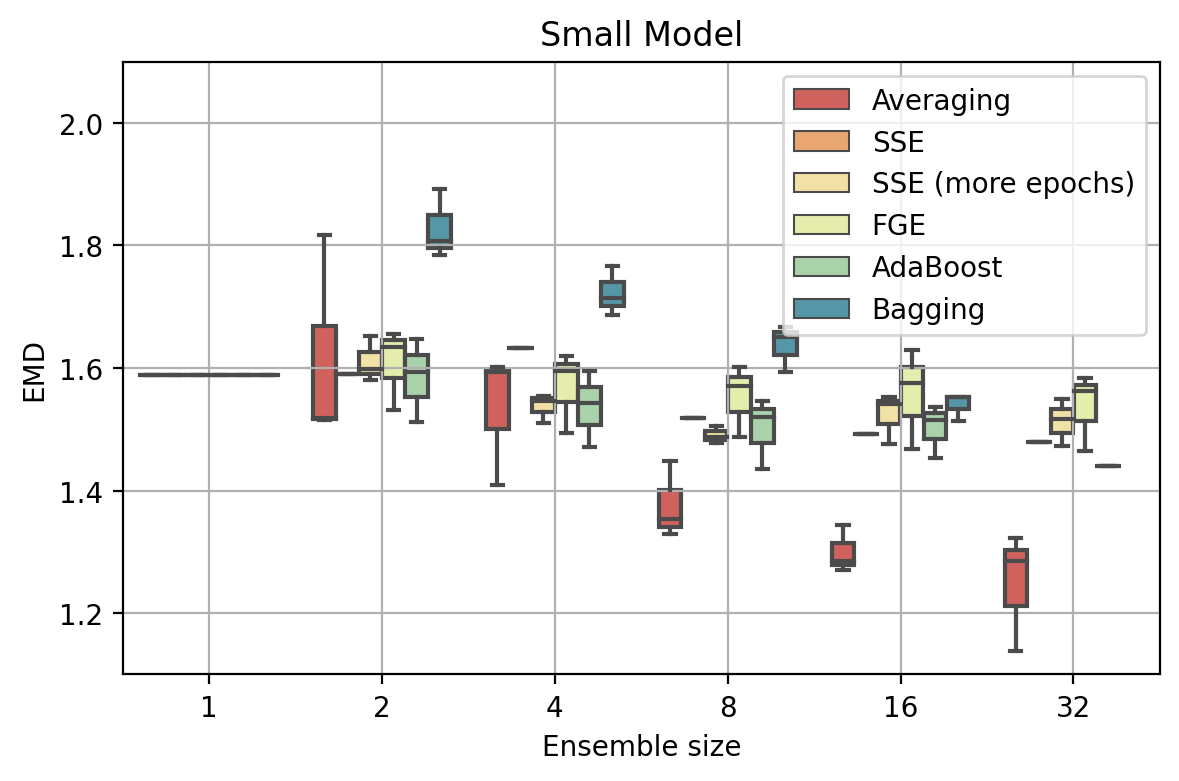

In [38]:
"""
Boxplot comparing all methods (Small model)
"""
fig, ax = plt.subplots(figsize=(6, 4))

small_df = all_df[all_df["model_size"] == "small"]

ax = sns.boxplot(data=small_df, x="ensemble_size", y="emd", hue="ensemble_method", palette="Spectral")

ax.grid()
ax.legend()
ax.set_ylim([1.1, 2.1])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Small Model")

fig.tight_layout()

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

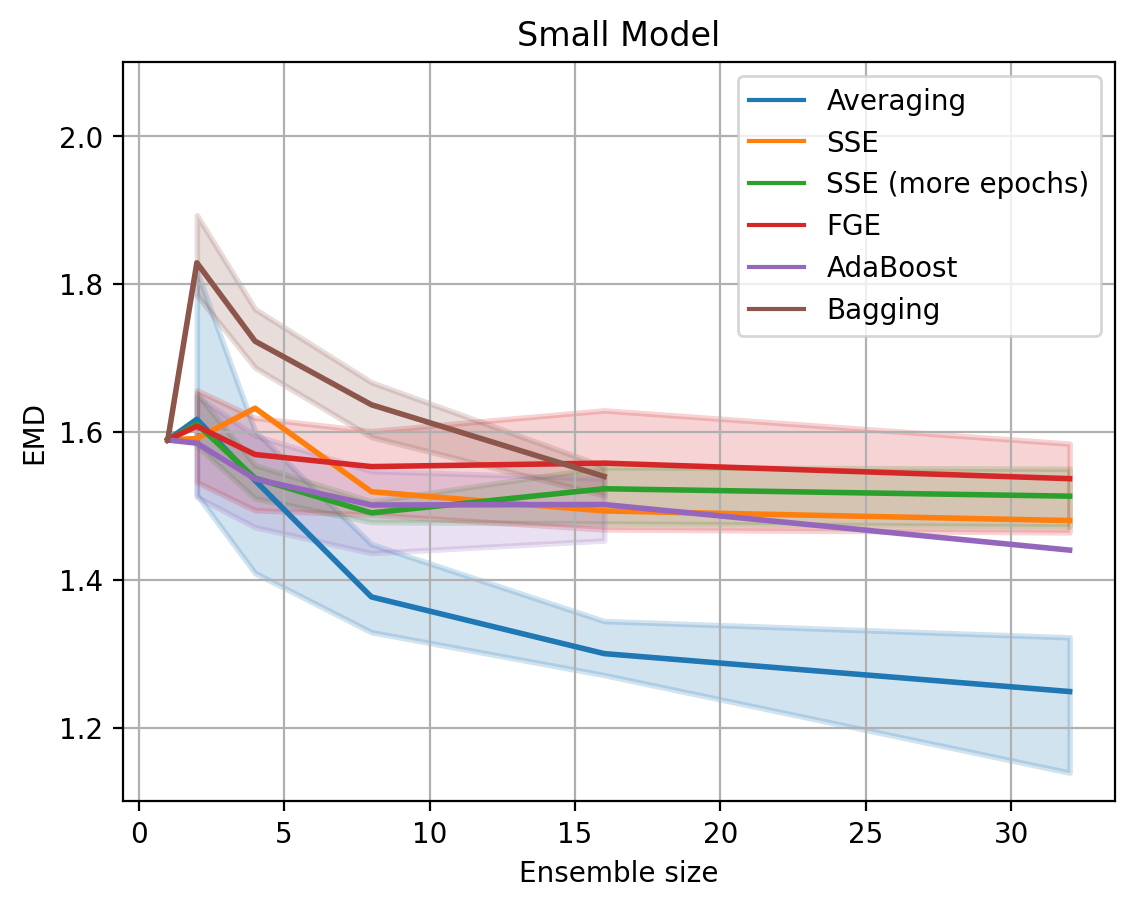

In [39]:
ax = sns.lineplot(
    data=small_df, 
    x="ensemble_size", 
    y="emd", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

ax.grid()
ax.legend()
ax.set_ylim([1.1, 2.1])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Small Model")

fig.tight_layout()

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

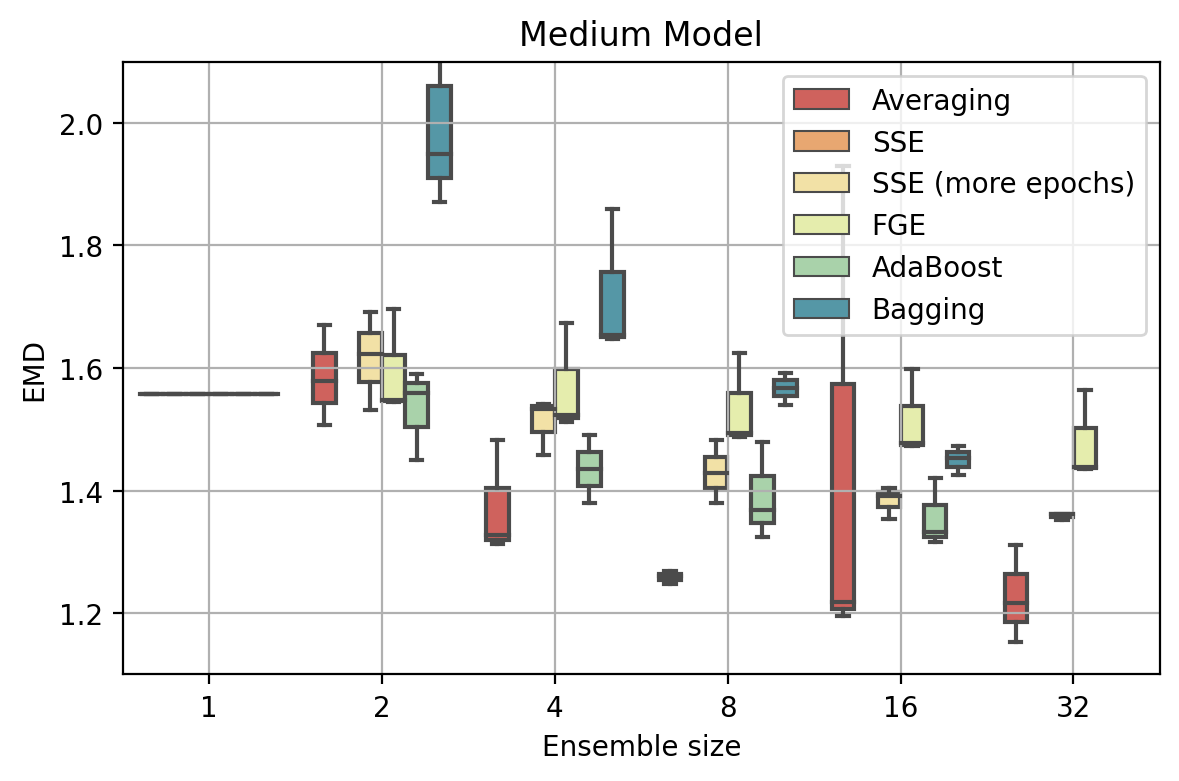

In [40]:
"""
Boxplot comparing all methods (Medium model)
"""
fig, ax = plt.subplots(figsize=(6, 4))

med_df = all_df[all_df["model_size"] == "medium"]

ax = sns.boxplot(data=med_df, x="ensemble_size", y="emd", hue="ensemble_method", palette="Spectral")

ax.grid()
ax.legend()
ax.set_ylim([1.1, 2.1])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Medium Model")

fig.tight_layout()

/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/proj/xlabs/users/olivweng/opt/mambaforge/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

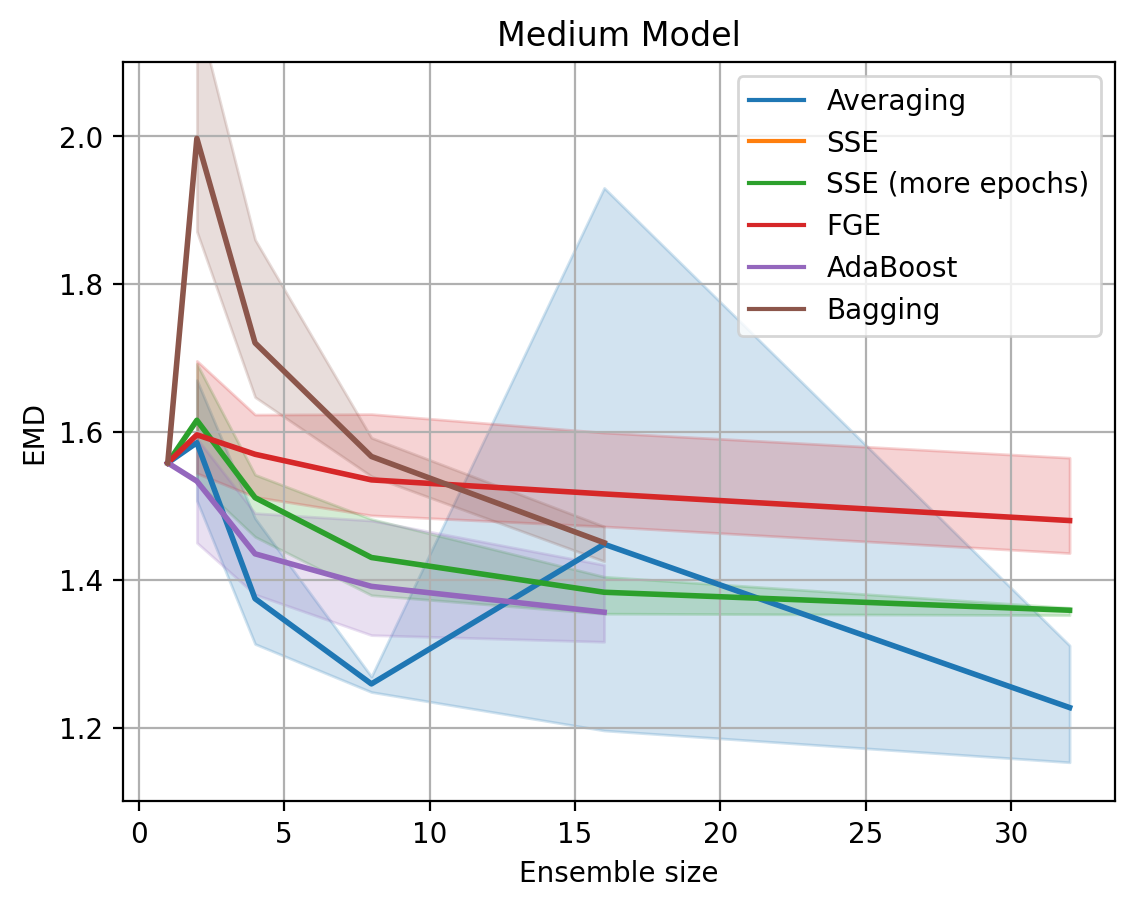

In [41]:
ax = sns.lineplot(data=med_df, x="ensemble_size", y="emd", hue="ensemble_method", linewidth=2)

ax.grid()
ax.legend()
ax.set_ylim([1.1, 2.1])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("EMD")
ax.set_title("Medium Model")

fig.tight_layout()